# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import gc, sys
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


!pip install lightgbm
import lightgbm as lgb 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

# magic word for producing visualizations in notebook
%matplotlib inline

    100% |████████████████████████████████| 1.2MB 11.8MB/s ta 0:00:01


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
def reduce_mem_usage(df, verbose=True):
    '''
    INPUT:
    df - a pandas dataframe containing raw data
    verbose - a Booler to determine print the result of storage decrease or not
    
    OUTPUT:
    
    This function will suppress INPUT.df by changing data type for storage
    '''
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose: print("Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(end_mem, 100 * (start_mem - end_mem) / start_mem))

    return df

### Step 0.1: Load Raw Data

In [0]:
# load in the data

azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
azdias.shape

(891221, 366)

In [0]:
customers.shape

(191652, 369)

In [0]:
azdias = reduce_mem_usage(azdias)
customers = reduce_mem_usage(customers)

Mem. usage decreased to 577.11 Mb (76.8% reduction)
Mem. usage decreased to 127.21 Mb (76.4% reduction)


In [9]:
# Load in the feature summary file.

feat_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=1)
feat_info.drop(["Unnamed: 0"], axis=1, inplace=True)
feat_map_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
feat_map_info.drop(["Unnamed: 0"], axis=1, inplace=True)

feat_info["Information level"].fillna(method='ffill', inplace=True)
feat_map_info["Attribute"].fillna(method='ffill', inplace=True)

### Step 0.2: Business Understanding

To get a better business understanding required by [CRISP-DM](https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome), the below three questions are set up and the solutions are added below. 

- Q1: Before model is applied, how to design an online experiment to show its effectiveness?
 
 A1: an online experiment mainly is used to give a proof of what model predicts. Thus, the design of online experiment relies on the model prediction or prediction requirements. By following these constraints and design procedures, an online experiment could be achieved. Then, compare the experiment results with model predictions to make finnal decisions on the deploy of model.
---
-  Q2: If model is applied and operates normally, how to quantify and evaluate the net income from model?
 
 A2: directly, the income by purchase increase in relative ares where model is deployed should be considered as earnings. Meanwhile, the cost of deploy such as computer power, maintenance and new employees should be treated as cost. Combine two types of income, we could obtain the net income.
---
- Q3: After model operates for a long time, how to deal with the differences between the model predictions and reviews by customers?

 A3: after deploying, cause there is no 100% accuracy for any model, there must exist some disagree cases or reviews. These cases could be added directly to balance original dataset. Meanwhile, if computer power is enough, *dynamic programming* could be applied to treat model bias automatically, which would save workload.



### Step 0.3: Data Understanding
Similar to the requirements of business understanding, the below three questions are set up for a better data understanding and the solutions are added below.

- Q1: How "big" is the datasets?
 
 A1:  by checking, two datasets contains about 100w cases in total, which do not agree with the common definition of "big data"
---
-  Q2: How imbalanced is the datasets?
 
 A2: as it is discussed in the first part of Step 0.3.1, the comparison graphs show that the distribution ratio of each feature in azdias and customers data are relatively small (commonly less than 6:1) which means imbalance problem could be omitted safely.
--- 
- Q3: How to deal with small sample data?

 A3: Generally, several methods such as over-sampling, under-sampling and Synthetic Data could be choosed. For this project, small sample data is checked in Step 0.3.2 to determine whether keep or not.

#### Step 0.3.1: Visiualize Checkings
Here features and calculated statistics relevant to the project are investigated and reported with proper visualizations. The explorations of data include survivor bias checking, statistical visualizations and repeatability checkings as below.

##### **1.** Survivor Bias (Imbalance checking)

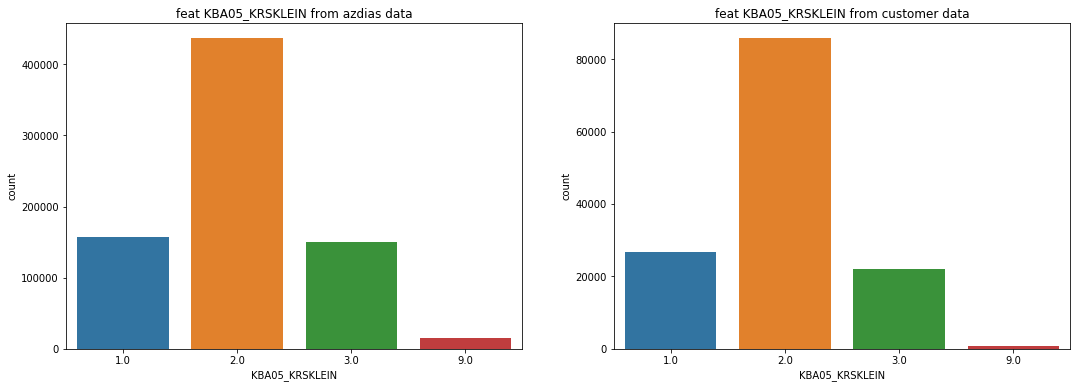

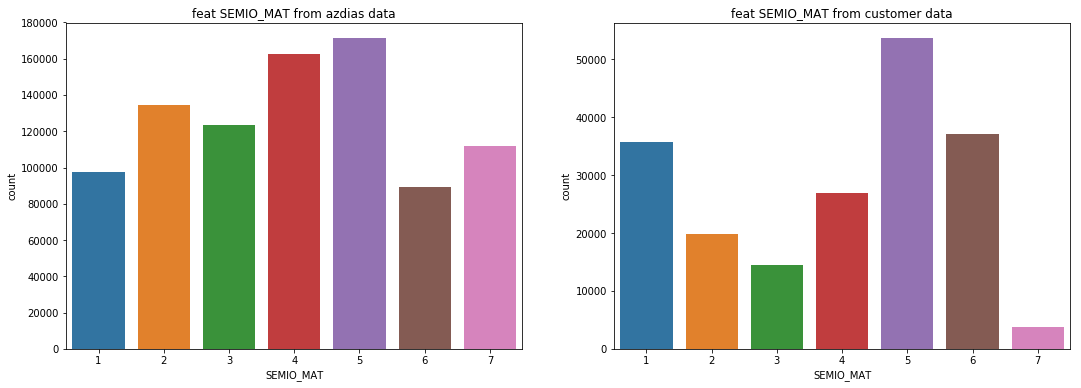

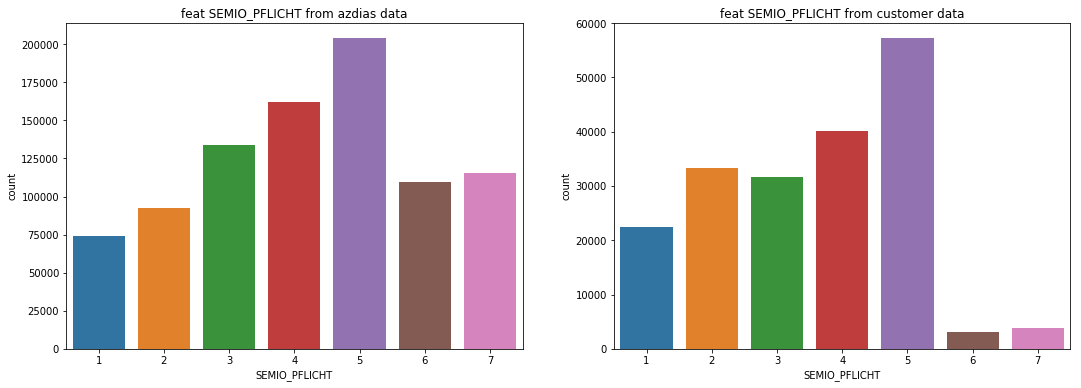

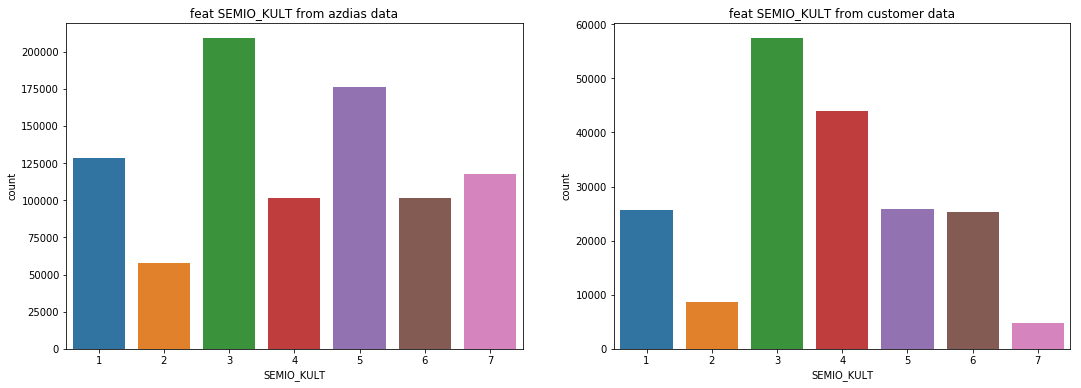

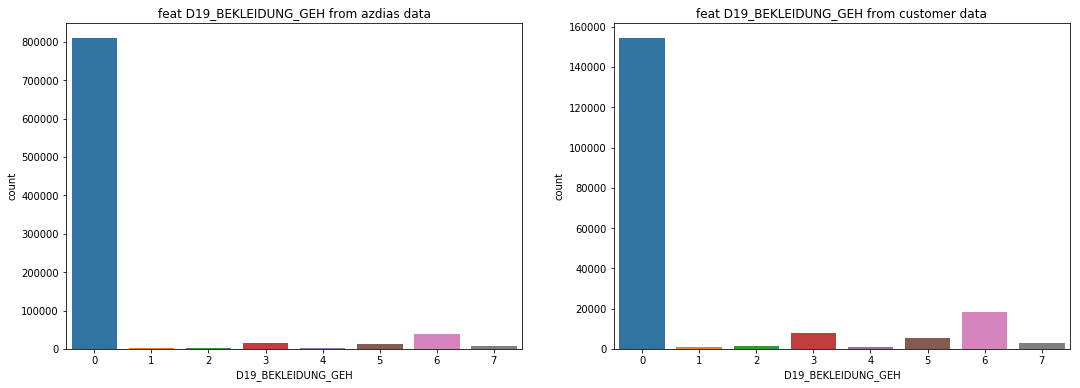

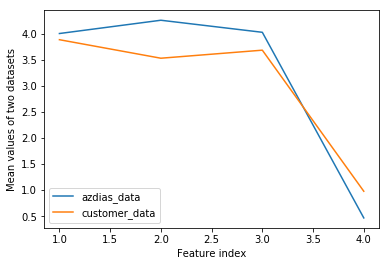

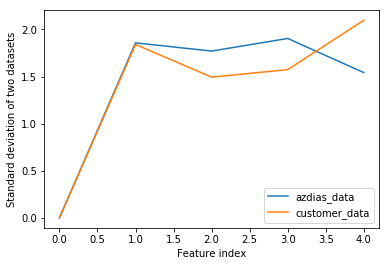

In [0]:
num = 5
mean_dict = {'azdias_data': [], 'customer_data':[]}
std_dict = {'azdias_data': [], 'customer_data':[]}
feat_selected = random.sample(list(azdias.columns), num)

for ind in range(num):
    feat = feat_selected[ind]
    fig = plt.figure(num=ind, figsize=(18, 6))
    
    ax1 = fig.add_subplot(121)
    ax1.set_title("feat %s from azdias data" %feat)
    mean_dict['azdias_data'].append(azdias[feat].dropna().mean())
    std_dict['azdias_data'].append(azdias[feat].dropna().std())
    sns.countplot(x=feat, data=azdias, ax=ax1);
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("feat %s from customer data" %feat)
    mean_dict['customer_data'].append(customers[feat].dropna().mean())
    std_dict['customer_data'].append(customers[feat].dropna().std())
    sns.countplot(x=feat, data=customers, ax=ax2);

mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
axes1 = mean_df.plot();
axes1.set_xlabel('Feature index');
axes1.set_ylabel ('Mean values of two datasets');
axes2 = std_df.plot();
axes2.set_xlabel('Feature index');
axes2.set_ylabel('Standard deviation of two datasets');
plt.show();

**Discussion for azdias and customers data**

Survivor bias here mainly focuses on the target distributions and the feature distributions to find out the the imbalance within the data. The comparisons above show that the distribution ratio of each feature in azdias and customers data are relatively small (commonly less than 6:1) which means imbalance problem could be omitted safely.

##### **2.** Statistical Visualizations

Apply brief display of four datasets and statistics of azdias and customers data.

In [0]:
print(azdias.head(10))
print(azdias.shape)

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   
5  910244         3         1.0      10.0          NaN          NaN   
6  910248        -1         9.0       0.0          NaN          NaN   
7  910261        -1         1.0      14.0          NaN          NaN   
8  645145        -1         9.0      16.0          NaN          NaN   
9  645153        -1         5.0      17.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0

In [0]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [0]:
print(customers.head(10))
print(customers.shape)

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   
5  143888         1         1.0      11.0          NaN          NaN   
6  143904         2         1.0      10.0          NaN          NaN   
7  143910         1         1.0      10.0          NaN          NaN   
8  102160         2         3.0       5.0          NaN          NaN   
9  102173         1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN

In [0]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


**Discussion  for azdias and customers data**
* There are 891221 pieces of data, 366 features in azdias dataset while 191652 pieces of data,  369 features in customers dataset. From statistical descriptions, both datasets have vacancies and differences in the order of data exist among two datasets.

##### **3.** Repeatability Checkings

Find out whether there is any duplicated piece of data existed in azdias and customers datasets.

In [0]:
azdias[azdias.duplicated()]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [0]:
customers[customers.duplicated()]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB


**Discussion for azdias and customers data**
* Obviously, there is no duplicte in both azdias data and customers data.

#### Step 0.3.2: Assess Missing Data

##### **1.** Convert Missing Value Codes to NaNs

What shall be done here is a little bit of parsing to make use of map relationship to identify and clean azdias and customers data. In details, theses cells below would convert data that matches a 'unknown' value in *DIAS Attributes - Values 2017.xlsx* into a numpy NaN value. 

In [11]:
gc.collect()
sys._clear_type_cache()

In [10]:
def split_str(x):
    '''
    INPUT:
    x - a pandas series parased by apply attribute
    
    OUTPUT:
     - a list containing value indications for unknown data
    
    This function will convert string to list, e.g from "-1, 0" to [-1, 0]
    '''
    val = x["Value"]
    return [int(item) for item in val.split(",")]


def select_unknown(x):
    '''
    INPUT:
    x - a pandas series parased by apply attribute
    
    OUTPUT:
     - a Boolen value indicating whether it is unknown
    
    This function will extract value indications for unknown data
    '''
    val = x["Meaning"]
    if "unknown" in val:
        return True
    else:
        return False


map_df = feat_map_info.loc[:, ["Attribute", "Value", "Meaning"]]
map_df.replace(" ", np.nan, inplace=True)
map_df = map_df[map_df["Meaning"].notnull()]
unknown_index = map_df.apply(select_unknown, axis=1)
map_unknown_df = map_df[unknown_index].loc[:, ["Attribute", "Value"]]
map_unknown_df.replace("-1", -1, inplace=True)

index = map_unknown_df.loc[:, "Value"].isin(["-1, 0", "-1, 9"])
map_unknown_df_part_ori = map_unknown_df[index]
map_unknown_df_part = map_unknown_df_part_ori.apply(split_str, axis=1)
map_unknown_df.loc[:, "Value"][index] = map_unknown_df_part

In [12]:
def replace_unkown(df, map_unknown_df):
    '''
    INPUT:
    df - a pandas dataframe containing raw data
    map_unknown_df - a pandas dataframe containing all map relationships of each feature
    
    OUTPUT:
    df_copy - a pandas dataframe with all unknown data replaced
    
    This function will replace data that matches a 'unknown' value by numpy NAN
    '''
    index = [True if each_attr in df.columns else False for each_attr in map_unknown_df["Attribute"]]
    unknown_attributes_list = list(map_unknown_df[index]["Attribute"])
    unknown_values_list = list(map_unknown_df[index]["Value"])
    
    change_actual = []
    df_copy = copy.copy(df)
    for indent, each_attribute in enumerate(unknown_attributes_list):
        vals = unknown_values_list[indent]
    
        try:
            len(vals) 
        except TypeError:
            index = (df_copy.loc[:, each_attribute] == vals)
            unkown = df_copy.loc[:, each_attribute][index]
            df_copy.loc[:, each_attribute][index] = unkown.apply(lambda x: np.nan)
            change_actual.append(unkown.shape[0])
        else:
            for each_val in vals:
                index = (df_copy.loc[:, each_attribute] == each_val)
                unkown = df_copy.loc[:, each_attribute][index]
                df_copy.loc[:, each_attribute][index] = unkown.apply(lambda x: np.nan)
                change_actual.append(unkown.shape[0])
                
    # check if all unknown values are replaced successfully     
    print((df_copy.isnull().sum().sum() - df.isnull().sum().sum()) == sum(change_actual))
        
    return df_copy

In [0]:
azdias_noUnknown = replace_unkown(azdias, map_unknown_df)
customers_noUnknown = replace_unkown(customers, map_unknown_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True
True


##### **2.** Assess Missing Data in Each Column

Here we would assess missing data which is present in each column. Among them, there are a few columns that are outliers in terms of the proportion of values that are missing. Theses cells below would visualize the distribution of missing value counts to find these columns while some of these columns might have justifications for keeping or re-encoding the data.

In [0]:
gc.collect()
sys._clear_type_cache()

* azdias dataset

In [0]:
azdias_column_vacancy_asses = azdias_noUnknown.isnull().mean()
azdias_feats, azdias_column_vacancy = \
    azdias_column_vacancy_asses.index, azdias_column_vacancy_asses.values

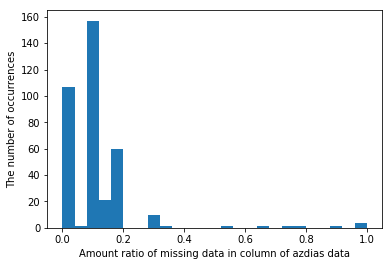

In [0]:
axes = azdias_column_vacancy_asses.hist(bins=25, ax=None, grid=False)
axes.set_xlabel("Amount ratio of missing data in column of azdias data");
axes.set_ylabel("The number of occurrences");
plt.show();

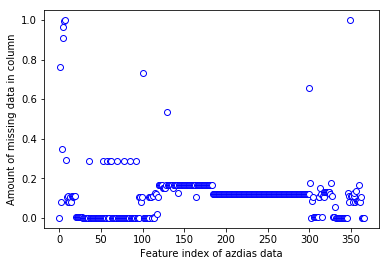

In [0]:
plt.plot(np.arange(azdias_feats.shape[0]), azdias_column_vacancy, 'bo', markerfacecolor="w")
plt.xlabel('Feature index of azdias data');
plt.ylabel ('Amount of missing data in column');
plt.show();

**Discussion for azdias data**

* Learned from the first graph, it is shown that there are more than 100 feats among 360 feats have no missing data. Most common missing ratio of azdias columns is near 15 percentage while least common missing ratio of azdias columns is near 95% percentage.
* As it is shown from the second graph, it is resonable to drop the feat whose vacancy ratio is greater than 0.4 to balance the loss of information and the benefit of a promising robust model. (In details, either filling or regression method for dealing with such amount of missing data may cast considerable human bias to the raw dataset)

In [0]:
# Remove the outlier columns from the dataset

remove_list = \
    [
        np.where(azdias_column_vacancy == each_num)[0][0] 
             for each_num in azdias_column_vacancy[azdias_column_vacancy > 0.4]
    ]
azdias_OutlierColumnRemoved = azdias_noUnknown.drop(azdias_feats[remove_list], axis=1)

In [0]:
azdias_OutlierColumnRemoved.shape

(891221, 357)

* customer dataset

In [0]:
customers_column_vacancy_asses = customers_noUnknown.isnull().mean()
customers_feats, customers_column_vacancy = \
    customers_column_vacancy_asses.index, customers_column_vacancy_asses.values

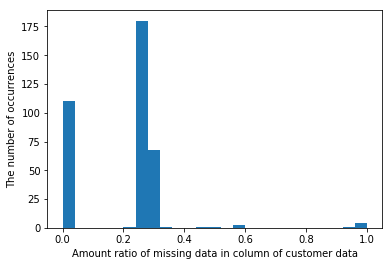

In [0]:
axes = customers_column_vacancy_asses.hist(bins=25, ax=None, grid=False)
axes.set_xlabel("Amount ratio of missing data in column of customer data");
axes.set_ylabel("The number of occurrences");
plt.show();

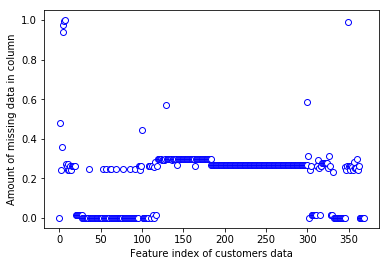

In [0]:
plt.plot(np.arange(customers_feats.shape[0]), customers_column_vacancy, 'bo', markerfacecolor="w")
plt.xlabel('Feature index of customers data');
plt.ylabel ('Amount of missing data in column');
plt.show();

**Discussion for customers data**

* For customers data, column missing value sharte obvious differences. Learned from the first graph, it is shown that there are more than 100 feats among 360 feats have no missing data which is similar to azdias dataset. However, most common missing ratio of customers columns is near 25 percentage while least common missing ratio of azdias columns is near 95% percentage.
* To keep with a same operation of azdias dataset, it is necessary to drop the feat whose vacancy ratio is greater than 0.4 for the customers dataset.

In [0]:
# Remove the outlier columns from the dataset

remove_list = \
    [
        np.where(customers_column_vacancy == each_num)[0][0] 
             for each_num in customers_column_vacancy[customers_column_vacancy > 0.4]
    ]
customers_OutlierColumnRemoved = customers_noUnknown.drop(azdias_feats[remove_list], axis=1)

In [0]:
customers_OutlierColumnRemoved.shape

(191652, 360)

##### **3.** Assess Missing Data in Each Row

Here we would perform a similar assessment for the rows of the dataset. Futhermore, datasets will be divided into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Five of these columns and compare the distribution of values are selected and visualized. Depending on what i observe in my comparison, these findings show some implications listed in my discussions below. 

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Either way, i would continue my analysis using just the subset of the data with few or no missing values.

In [0]:
gc.collect()
sys._clear_type_cache()

In [13]:
def compare_vacancy_dis(data_low_vacancy, data_high_vacancy, feat, ind):
    '''
    INPUT:
    data_low_vacancy - a pandas dataframe with low vancancy in row
    data_high_vacancy - a pandas dataframe with high vancancy in row
    feat -  a string indicating which feature to compare
    ind - an int number indicating the order of graph drawing
    
    OUTPUT:
    None
    
    This function will compare the distribution between data with low row vancancy
    and data with high row vacancy.
    '''
    fig = plt.figure(num=ind, figsize=(18, 6))
    
    ax1 = fig.add_subplot(121)
    ax1.set_title("feat %s from low vacancy data" %feat)
    mean_dict['low_vacancy_data'].append(data_low_vacancy[feat].dropna().mean())
    std_dict['low_vacancy_data'].append(data_low_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("feat %s from high vacancy data" %feat)
    mean_dict['high_vacancy_data'].append(data_high_vacancy[feat].dropna().mean())
    std_dict['high_vacancy_data'].append(data_high_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);

* azdias dataset

In [0]:
azdias_feats = azdias_OutlierColumnRemoved.columns
azdias_row_vacancy_asses = \
    np.array(
        [
            azdias_OutlierColumnRemoved.iloc[indent, :].isnull().sum() 
             for indent in range(azdias_OutlierColumnRemoved.shape[0])
        ]
    )

In [0]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_vacancy_ave = azdias_row_vacancy_asses.mean()
azdias_OutlierColumnRemoved_low = \
    azdias_OutlierColumnRemoved[:][azdias_row_vacancy_asses <= row_vacancy_ave]  # lower than average number
azdias_OutlierColumnRemoved_high = \
    azdias_OutlierColumnRemoved[:][azdias_row_vacancy_asses > row_vacancy_ave]  # higher than average number

In [0]:
mean_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}
std_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}
sns.set(style="darkgrid")

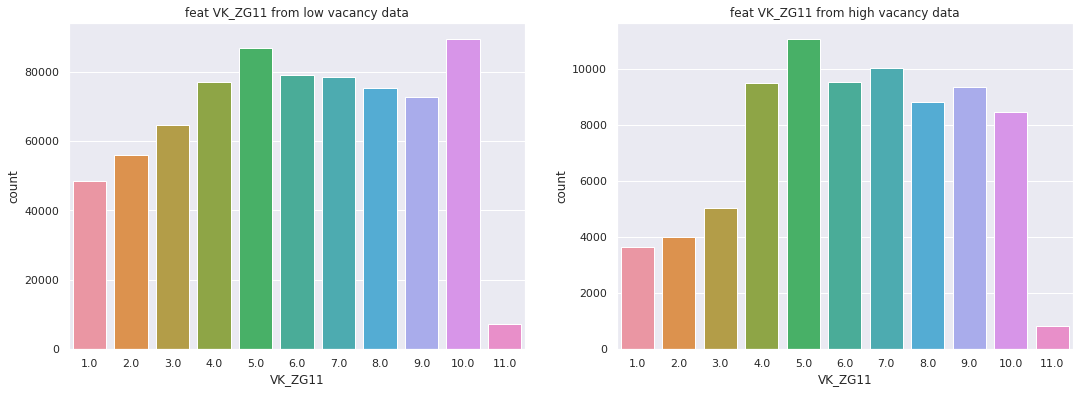

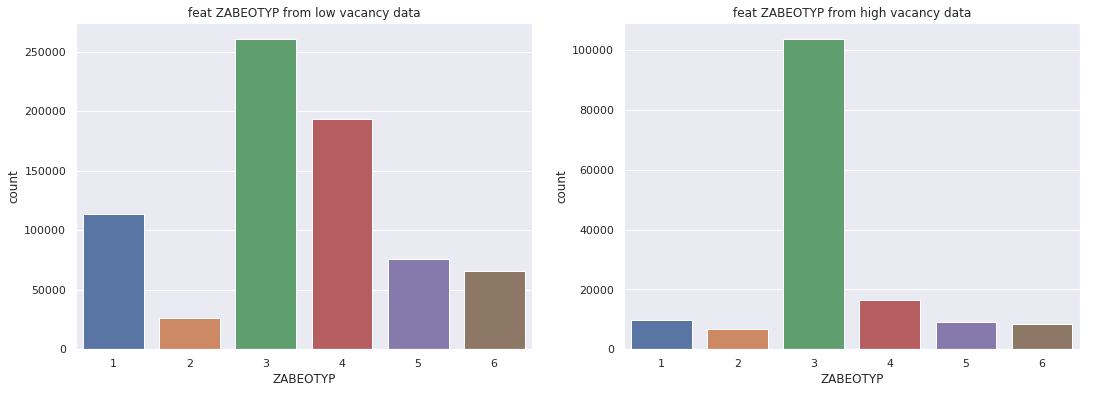

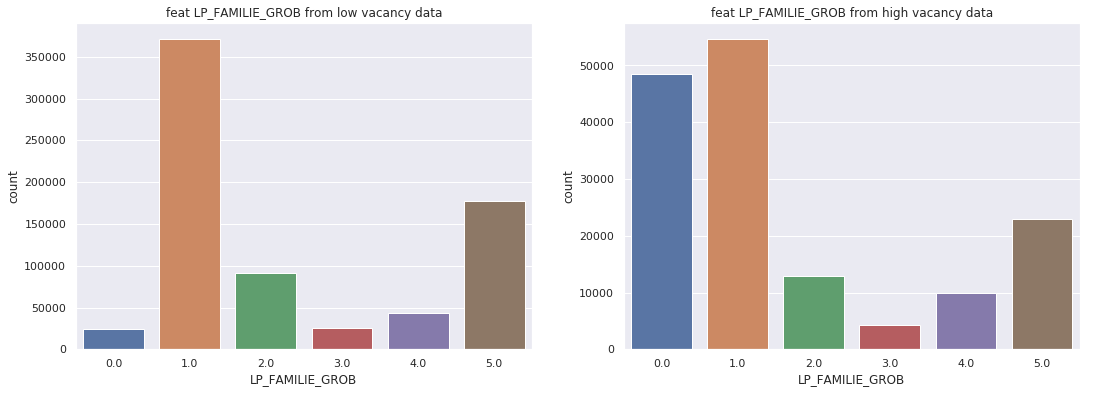

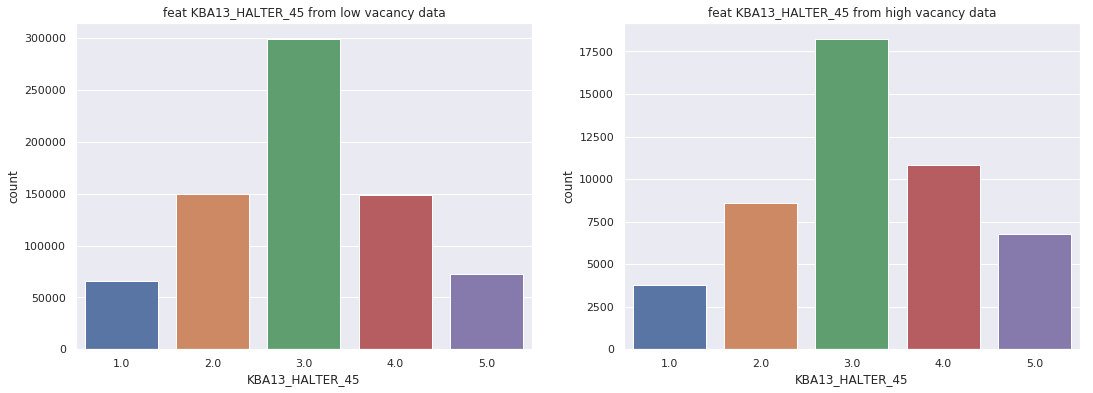

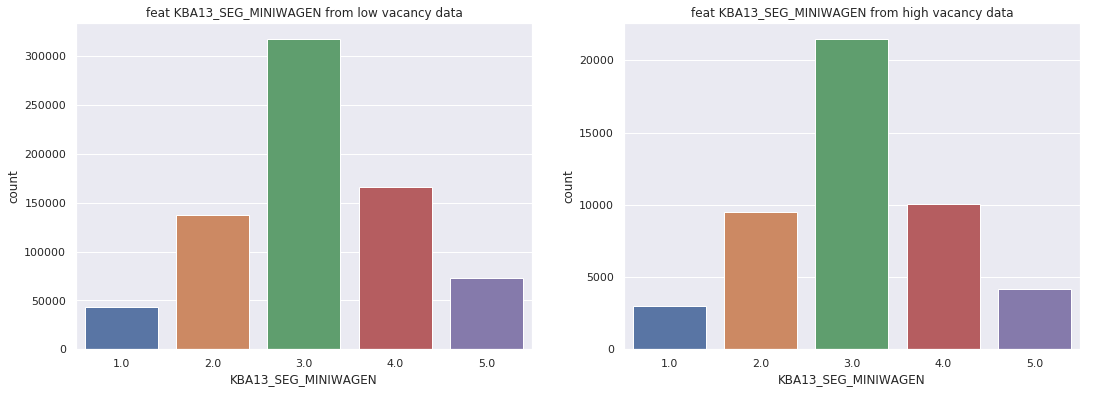

In [0]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

num = 5
feat_selected = random.sample(list(azdias_feats), num)

for indent in range(num):
    compare_vacancy_dis(
        azdias_OutlierColumnRemoved_low, 
        azdias_OutlierColumnRemoved_high, 
        feat_selected[indent], 
        indent)

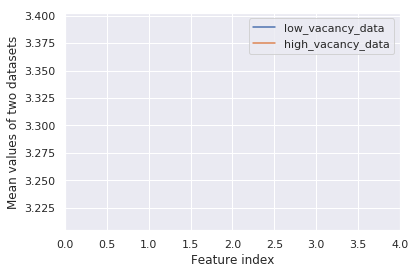

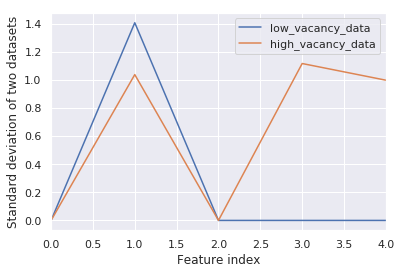

In [0]:
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)

axes1 = mean_df.plot();
axes1.set_xlabel('Feature index');
axes1.set_ylabel ('Mean values of two datasets');
axes2 = std_df.plot();
axes2.set_xlabel('Feature index');
axes2.set_ylabel('Standard deviation of two datasets');
plt.show();

**Discussion for azdias data**

* From the visualized distributions and statistics like mean and standard deviation shown above, the data with lots of missing values are qualitatively different with data that has few or no missing values. As a result, no drop would be taken and a special notice on those data would be added.

* customer dataset

In [0]:
customers_feats = customers_OutlierColumnRemoved.columns
customers_row_vacancy_asses = \
    np.array(
        [
            customers_OutlierColumnRemoved.iloc[indent, :].isnull().sum() 
             for indent in range(customers_OutlierColumnRemoved.shape[0])
        ]
    )

In [0]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_vacancy_ave = customers_row_vacancy_asses.mean()
customers_OutlierColumnRemoved_low = \
    customers_OutlierColumnRemoved[:][customers_row_vacancy_asses <= row_vacancy_ave]  # lower than average number
customers_OutlierColumnRemoved_high = \
    customers_OutlierColumnRemoved[:][customers_row_vacancy_asses > row_vacancy_ave]  # higher than average number

In [0]:
mean_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}
std_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}
sns.set(style="darkgrid")

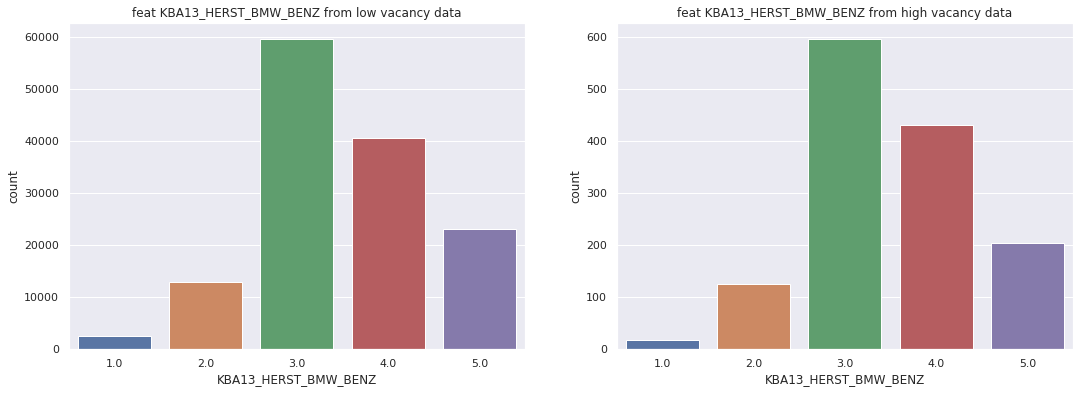

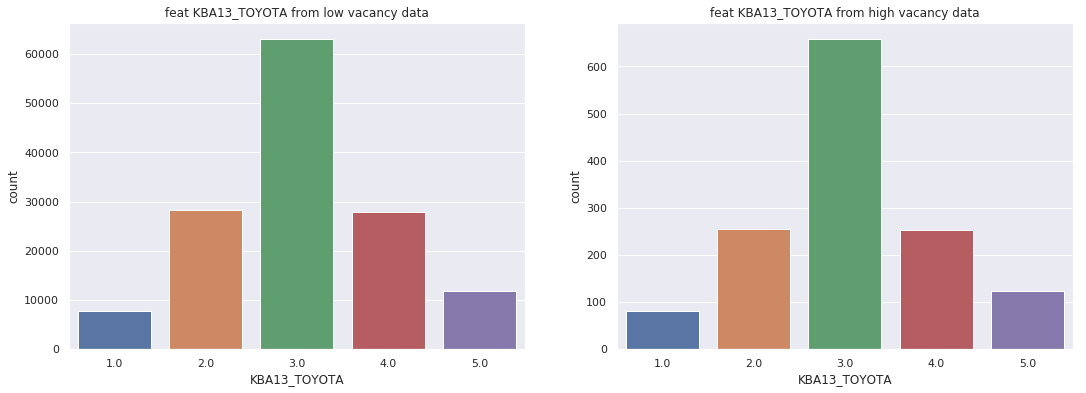

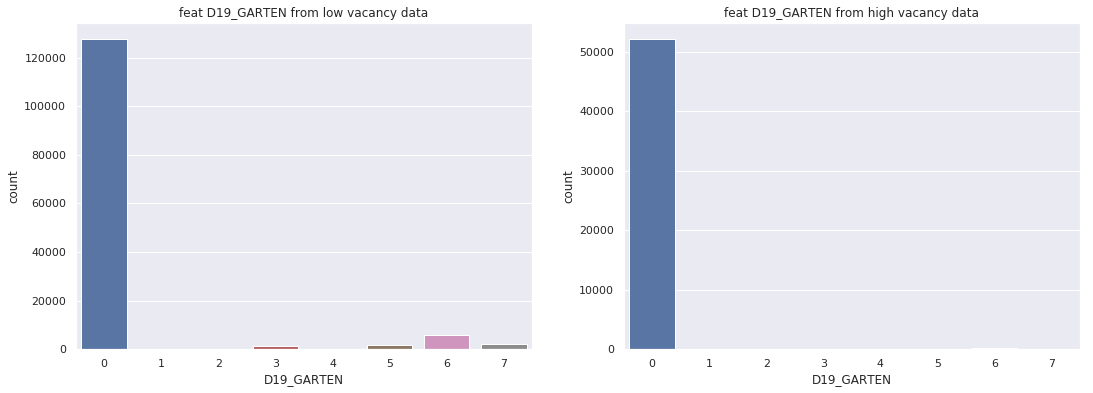

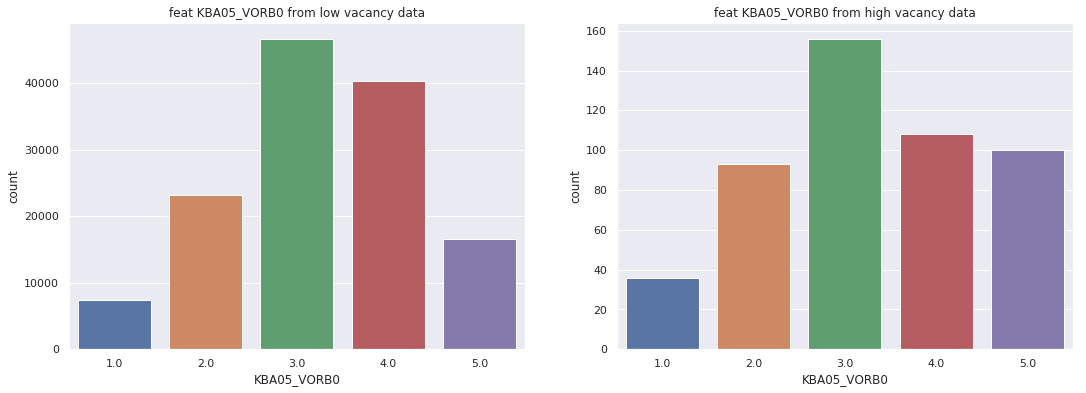

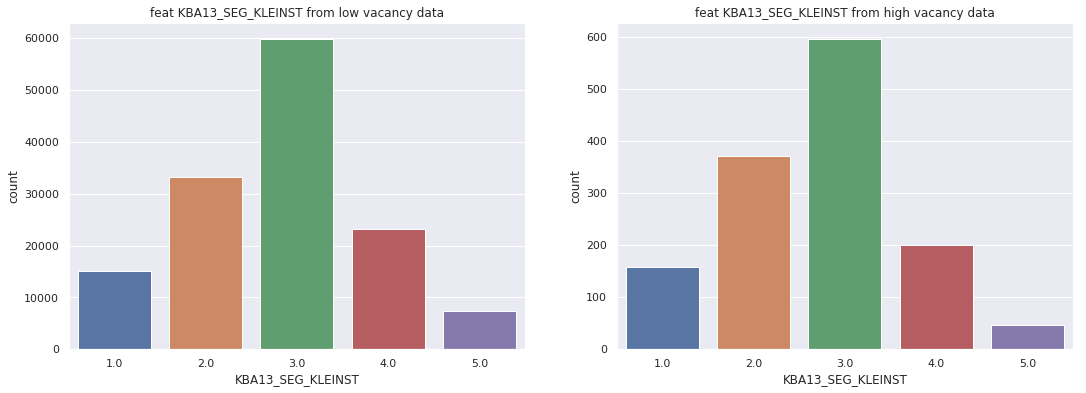

In [0]:
num = 5
feat_selected = random.sample(list(customers_feats), num)

for indent in range(num):
    compare_vacancy_dis(
        customers_OutlierColumnRemoved_low, 
        customers_OutlierColumnRemoved_high, 
        feat_selected[indent], 
        indent)

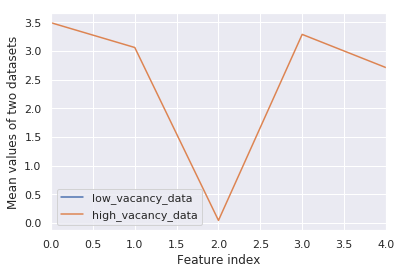

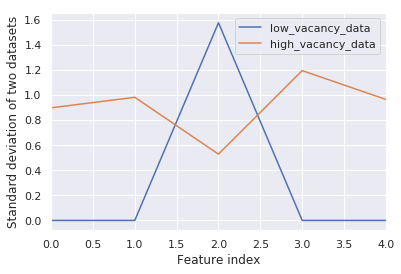

In [0]:
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)

axes1 = mean_df.plot();
axes1.set_xlabel('Feature index');
axes1.set_ylabel('Mean values of two datasets');
axes2 = std_df.plot();
axes2.set_xlabel('Feature index');
axes2.set_ylabel('Standard deviation of two datasets');
plt.show();

**Discussion for azdias data**

* Similar to the azdias data, the data with lots of missing values are qualitatively different with data that has few or no missing values. As a result, no drop would be taken and a special notice on those data would be added.

In [0]:
del azdias_noUnknown
del customers_noUnknown

#### Step 0.3.3: Feature Engineering

##### **1.** Select and Re-Encode

Checking for missing data isn't the only way to prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, this step mainly focuses on how to convert all categorical features to numberic featires.
 
In details, this step includes two parts to deal with binary features and multi-class features for azdias and customers dataset repectively.

In [15]:
gc.collect()
sys._clear_type_cache()

In [14]:
def convert_to_century(x):
    '''
    INPUT:
    x - a pandas series parased from data
    
    OUTPUT:
     - century name associated with different years
    
    This function will compute the name of the century corresponding to each year.
    '''
    if np.isnan(x):
        return x
    else:
        val = int(x // 100 + 1)
        return val - century_min + 1  

* azdias dataset

In [0]:
# for data neither mentioned in two excel files:  
# *DIAS Information Levels - Attributes 2017.xlsx* and *DIAS Attributes - Values 2017.xlsx*,
# replace them with np.NAN

azdias_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].replace("X", np.nan, inplace=True)
azdias_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"] = \
    azdias_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].astype("float")

azdias_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].replace("XX", np.nan, inplace=True)
azdias_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"] = \
    azdias_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].astype("float")

In [0]:
azdias_feat_types = azdias_OutlierColumnRemoved.dtypes
azdias_categ = azdias_feat_types[azdias_feat_types == "object"]
azdias_OutlierColumnRemoved_categorical = azdias_OutlierColumnRemoved.loc[:, azdias_categ.index]

feats_binary, feats_multi = [], []

# divide all categorical features into binary and multi-class features
for each_feat in azdias_categ.index:
    temp = set(azdias_OutlierColumnRemoved_categorical[each_feat].dropna().values)
    if len(temp) == 2:
        feats_binary.append(each_feat)
    else:
        feats_multi.append(each_feat)
del azdias_OutlierColumnRemoved_categorical

**re-encode for binary features**

In [0]:
for feat in feats_binary:
    temp = azdias_OutlierColumnRemoved.loc[:, feat]
    
    vals = list(set(temp.dropna().values))
    map_dict = {vals[0]: 0, vals[1]:1}
    azdias_OutlierColumnRemoved.loc[:, feat] = \
        temp.map(map_dict)
    
    del temp

**re-encode for multi-class features**

In [0]:
# deal with the datetime data

feats_multi.remove("EINGEFUEGT_AM")
azdias_date_series = \
    pd.DataFrame(
        pd.to_datetime(azdias_OutlierColumnRemoved.loc[:, "EINGEFUEGT_AM"])
    )
azdias_date_series["Year"] = azdias_date_series["EINGEFUEGT_AM"].apply(lambda x: x.year)

temp = azdias_date_series["Year"]
century_max, century_min = \
    int(temp.max() // 100 + 1), int(temp.min() // 100 + 1)      

azdias_date_series["Century"] = azdias_date_series["Year"].apply(convert_to_century)
del temp

temp = pd.get_dummies(azdias_date_series["Century"])
names = ["Century_"+str(val)+"'s" for val in range(century_min, century_max+1)]
temp.columns = names
azdias_OutlierColumnRemoved = \
    pd.concat(
        [azdias_OutlierColumnRemoved, temp], axis=1
    )
del azdias_date_series

In [0]:
# deal with the left muti-class data

azdias_feats = azdias_OutlierColumnRemoved.columns
feats_multi = np.array(feats_multi)
feats_all = np.array(azdias_feats)
feats_all_nomulti = \
    np.delete(
        feats_all, 
        [np.where(feats_all == each_feat)[0][0] for each_feat in feats_multi]
    )

azdias_OutlierColumnRemoved_remain = azdias_OutlierColumnRemoved[feats_all_nomulti][:]
azdias_OutlierColumnRemoved_ReEncoded_multi = \
    pd.get_dummies(azdias_OutlierColumnRemoved[feats_multi], drop_first=True)
azdias_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
        [azdias_OutlierColumnRemoved_ReEncoded_multi, azdias_OutlierColumnRemoved_remain], axis=1
    )

del azdias_OutlierColumnRemoved_remain
del azdias_OutlierColumnRemoved_ReEncoded_multi

In [0]:
azdias_OutlierColumnRemoved_ReEncoded.shape

(891221, 435)

In [0]:
del azdias_OutlierColumnRemoved

* customer dataset

**re-encode for  categorical features** 

In [0]:
# for data neither mentioned in two excel files:  
# *DIAS Information Levels - Attributes 2017.xlsx* and *DIAS Attributes - Values 2017.xlsx*,
# replace them with np.NAN

customers_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].replace("X", np.nan, inplace=True)
customers_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"] = \
    customers_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].astype("float")

customers_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].replace("XX", np.nan, inplace=True)
customers_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"] = \
    customers_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].astype("float")

In [0]:
customers_feat_types = customers_OutlierColumnRemoved.dtypes
customers_categ = customers_feat_types[customers_feat_types == "object"]
customers_OutlierColumnRemoved_categorical = \
    customers_OutlierColumnRemoved.loc[:, customers_categ.index]

feats_binary, feats_multi = [], []

# divide all categorical features into binary and multi-class features
for each_feat in customers_categ.index:
    temp = set(customers_OutlierColumnRemoved_categorical[each_feat].dropna().values)
    if len(temp) == 2:
        feats_binary.append(each_feat)
    else:
        feats_multi.append(each_feat)
del customers_OutlierColumnRemoved_categorical

**re-encode for binary features**

In [0]:
for feat in feats_binary:
    temp = customers_OutlierColumnRemoved.loc[:, feat]
    
    vals = list(set(temp.dropna().values))
    map_dict = {vals[0]: 0, vals[1]:1}
    customers_OutlierColumnRemoved.loc[:, feat] = \
        temp.map(map_dict)
    
    del temp

**re-encode for multi-class features**

In [0]:
# deal with the datetime data

feats_multi.remove("EINGEFUEGT_AM")
customers_date_series = \
    pd.DataFrame(
        pd.to_datetime(customers_OutlierColumnRemoved.loc[:, "EINGEFUEGT_AM"])
    )
customers_date_series["Year"] = customers_date_series["EINGEFUEGT_AM"].apply(lambda x: x.year)

temp = customers_date_series["Year"]
century_max, century_min = \
    int(temp.max() // 100 + 1), int(temp.min() // 100 + 1)

customers_date_series["Century"] = customers_date_series["Year"].apply(convert_to_century)
del temp

temp = pd.get_dummies(customers_date_series["Century"])
names = ["Century_"+str(val)+"'s" for val in range(century_min, century_max+1)]
temp.columns = names
customers_OutlierColumnRemoved = \
    pd.concat(
        [customers_OutlierColumnRemoved, temp], axis=1
    )
del customers_date_series

In [0]:
# deal with the left muti-class data

customers_feats = customers_OutlierColumnRemoved.columns
feats_multi = np.array(feats_multi)
feats_all = np.array(customers_feats)
feats_all_nomulti = \
    np.delete(
        feats_all, 
        [np.where(feats_all == each_feat)[0][0] for each_feat in feats_multi]
    )

customers_OutlierColumnRemoved_remain = customers_OutlierColumnRemoved[feats_all_nomulti][:]
customers_OutlierColumnRemoved_ReEncoded_multi = \
    pd.get_dummies(customers_OutlierColumnRemoved[feats_multi], drop_first=True)
customers_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
        [customers_OutlierColumnRemoved_ReEncoded_multi, customers_OutlierColumnRemoved_remain], 
        axis=1
    )

del customers_OutlierColumnRemoved_remain
del customers_OutlierColumnRemoved_ReEncoded_multi

In [0]:
customers_OutlierColumnRemoved_ReEncoded.shape

(191652, 439)

In [0]:
del customers_OutlierColumnRemoved

**Discussion for azdias and customers data**

* BInary features: replace binary data by mapping dictionary {"label0": 0, "label1": 1} directly to decrease the storage room need.
* Multi-class features: for datetime data, extract century information to create new features; for the left features, create dummies for each feature while dropping original features with the consideration of the upcoming need of the apply of dimension reduction.

##### **2.** Engineer Mixed-Type Features

To recognize mixed features, here a simple search method is applied to 'DIAS Attributes - Values 2017.xlsx' file. If there is any "mixed" or "+" affixed to the "Meaning" column in this excel file, the attribute will be recognized as "mixed". Then, by comparing the "Description" column in the "DIAS Information Levels - Attributes 2017.xlsx" file, drop the faked one. Besides these, there are two mixed features that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Decisions for other mixed features are recorded in the discussion cell.

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
# try to find mixed features

part = \
    feat_map_info[feat_map_info["Attribute"]\
                  .isin(customers.columns)]
index =[]

for item in part["Meaning"].values:
    if 'float' in str(type(item)):
        index.append(False) 
    elif "+" in item or "mixed" in item:
        index.append(True) 
    else:
        index.append(False) 
        
mixed_features_list = list(set(part.loc[index, "Attribute"]))

In [0]:
# by manual checking from "DIAS Information Levels - Attributes 2017.xlsx", drop false mixed features 

mixed_features_list.remove("GEBAEUDETYP_RASTER")
mixed_features_list.remove("GEBAEUDETYP")
mixed_features_list

['PRAEGENDE_JUGENDJAHRE']

* azdias dataset

In [0]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Note: regard 'avantgrade' as 0
PRAEGENDE_JUGENDJAHRE_divided = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] 
ruler = \
    {1:[40, 1], 
     2:[40, 0], 
     3:[50, 1], 
     4:[50, 0], 
     5:[60, 1], 
     6:[60, 0], 
     7:[60, 0], 
     8:[70, 1], 
     9:[70, 0], 
     10:[80, 1], 
     11:[80, 0], 
     12:[80, 1], 
     13:[80, 0], 
     14:[90, 1], 
     15:[90, 0]}

data = azdias_OutlierColumnRemoved_ReEncoded["PRAEGENDE_JUGENDJAHRE"].map(ruler)
azdias_OutlierColumnRemoved_ReEncoded.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)

data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
PRAEGENDE_JUGENDJAHRE_divided_df = \
    pd.DataFrame(
        data=[np.array(each_value).squeeze() for each_value in data], 
        columns=PRAEGENDE_JUGENDJAHRE_divided
    )
azdias_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
    [
         azdias_OutlierColumnRemoved_ReEncoded, 
         PRAEGENDE_JUGENDJAHRE_divided_df
    ],
    axis=1) 

# Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_2015_divided = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']

data = \
    azdias_OutlierColumnRemoved_ReEncoded["CAMEO_INTL_2015"]\
        .astype('float')\
        .map(lambda x: [x//10, x%10])
azdias_OutlierColumnRemoved_ReEncoded.drop(["CAMEO_INTL_2015"], axis=1, inplace=True)

data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
CAMEO_INTL_2015_divided_df = \
    pd.DataFrame(
        data=[np.array(each_value).squeeze() for each_value in data], 
        columns=CAMEO_INTL_2015_divided
    )
azdias_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
    [
        azdias_OutlierColumnRemoved_ReEncoded, 
        CAMEO_INTL_2015_divided_df
    ], 
    axis=1)

In [0]:
azdias_OutlierColumnRemoved_ReEncoded.shape

(891221, 437)

* customer dataset

In [0]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Note: regard 'avantgrade' as 0
PRAEGENDE_JUGENDJAHRE_divided = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] 
ruler = \
    {1:[40, 1], 
     2:[40, 0], 
     3:[50, 1], 
     4:[50, 0], 
     5:[60, 1], 
     6:[60, 0], 
     7:[60, 0], 
     8:[70, 1], 
     9:[70, 0], 
     10:[80, 1], 
     11:[80, 0], 
     12:[80, 1], 
     13:[80, 0], 
     14:[90, 1], 
     15:[90, 0]}

data = customers_OutlierColumnRemoved_ReEncoded["PRAEGENDE_JUGENDJAHRE"].map(ruler)
customers_OutlierColumnRemoved_ReEncoded.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)

data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
PRAEGENDE_JUGENDJAHRE_divided_df = \
    pd.DataFrame(
        data=[np.array(each_value).squeeze() for each_value in data], 
        columns=PRAEGENDE_JUGENDJAHRE_divided
    )
customers_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
    [
         customers_OutlierColumnRemoved_ReEncoded, 
         PRAEGENDE_JUGENDJAHRE_divided_df
    ],
    axis=1) 

# Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_2015_divided = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']

data = \
    customers_OutlierColumnRemoved_ReEncoded["CAMEO_INTL_2015"]\
        .astype('float')\
        .map(lambda x: [x//10, x%10])
customers_OutlierColumnRemoved_ReEncoded.drop(["CAMEO_INTL_2015"], axis=1, inplace=True)

data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
CAMEO_INTL_2015_divided_df = \
    pd.DataFrame(
        data=[np.array(each_value).squeeze() for each_value in data], 
        columns=CAMEO_INTL_2015_divided
    )
customers_OutlierColumnRemoved_ReEncoded = \
    pd.concat(
    [
        customers_OutlierColumnRemoved_ReEncoded, 
        CAMEO_INTL_2015_divided_df
    ], 
    axis=1)

In [0]:
customers_OutlierColumnRemoved_ReEncoded.shape

(191652, 441)

**Discussion for azdias and customers data**

* Because after selection and manual checking, the confirmed mixed features only contains "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" , convertions of two features for two datasets by instructions listed at the beginning is applied to have a better understanding of these features.

##### **3.** Changes in features

In order to finish this step up, this step is used to make sure that data frames now only has the columns that we want to keep. To summarize, there checkings are applied:

(1) the dataframe obtained now should consist the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

(2) for any new columns that have been engineered, the original columns shall be excluded from the final datasets and only the values derived from engineered features that created above should be retained. 

(3) data should only include the subset with **few or no missing values**. 

In [0]:
gc.collect()
sys._clear_type_cache()

* azdias dataset

In [0]:
# exclude the left original features from two datasets

azdias_OutlierColumnRemoved_ReEncoded.drop(["EINGEFUEGT_AM"], axis=1, inplace=True)

In [0]:
# check the type of each feature

type_check = azdias_OutlierColumnRemoved_ReEncoded.dtypes
type_check.value_counts()

float16    265
int8        85
uint8       80
float64      4
int32        1
int16        1
dtype: int64

In [0]:
# check the missing values distribution

azdias_OutlierColumnRemoved_ReEncoded.isnull().mean().value_counts().sort_index(ascending=False)

0.348137      1
0.295041      1
0.288495      8
0.177357      2
0.166193      1
0.166188     54
0.166051      1
0.165168      1
0.164422      1
0.149597      6
0.135989      1
0.130736      7
0.124768      3
0.123468      1
0.121536      1
0.121366      2
0.120735      1
0.118714    116
0.111479      3
0.109721      2
0.109260      1
0.109147      3
0.109082      2
0.108848      1
0.105182      3
0.104525      3
0.104517      9
0.085183      3
0.082997      1
0.082470      9
0.057478      1
0.020587      1
0.005446     19
0.000000    167
dtype: int64

* customer dataset

In [0]:
# exclude the left original features from two datasets

customers_OutlierColumnRemoved_ReEncoded.drop(["EINGEFUEGT_AM"], axis=1, inplace=True)

In [0]:
# check the missing values distribution

customers_OutlierColumnRemoved_ReEncoded.isnull().mean().value_counts().sort_index(ascending=False)

0.358707      1
0.313401      2
0.297085      1
0.296965      1
0.296960     54
0.296668      1
0.296637      1
0.292102      1
0.292092      5
0.283117      1
0.280415      1
0.275312      7
0.271899      1
0.270501      1
0.267574    116
0.267245      1
0.263780      3
0.263493      1
0.263373      5
0.263227      2
0.260676      3
0.260509     12
0.255620      3
0.254367      1
0.252995      2
0.249781      3
0.248873      8
0.243415      1
0.243128      9
0.230585      1
0.016765     19
0.015486      1
0.000000    171
dtype: int64

In [0]:
# check the type of each feature

type_check = customers_OutlierColumnRemoved_ReEncoded.dtypes
type_check.value_counts()

float16    265
int8        87
uint8       82
float64      4
int32        1
int16        1
dtype: int64

**Discussion for azdias and customers data**

* As shown in above cells, after three checkings, two datasets: azdias data and cystomers data are available for the next step now. 


##### **4.** Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [0]:
gc.collect()
sys._clear_type_cache()

* azdias dataset

In [0]:
filler_vacancy = Imputer()

azdias_OutlierColumnRemoved_ReEncoded_nonull = \
    pd.DataFrame(
        data=filler_vacancy.fit_transform(azdias_OutlierColumnRemoved_ReEncoded),
        columns=azdias_OutlierColumnRemoved_ReEncoded.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
scaler_std = StandardScaler()

azdias_OutlierColumnRemoved_ReEncoded_scaled = \
    pd.DataFrame(
        data=scaler_std.fit_transform(azdias_OutlierColumnRemoved_ReEncoded_nonull),
        columns=azdias_OutlierColumnRemoved_ReEncoded_nonull.columns)

* customer dataset

In [0]:
# Apply feature transformation from the azdias data onto the customer data

customers_OutlierColumnRemoved_ReEncoded_nonull = \
    pd.DataFrame(
        data=filler_vacancy.transform(customers_OutlierColumnRemoved_ReEncoded),
        columns=customers_OutlierColumnRemoved_ReEncoded.columns)

customers_OutlierColumnRemoved_ReEncoded_scaled = \
    pd.DataFrame(
        data=scaler_std.transform(customers_OutlierColumnRemoved_ReEncoded_nonull),
        columns=customers_OutlierColumnRemoved_ReEncoded_nonull.columns)

**Discussion for azdias and customers data**
* Commonly using filling null by mean value and standard scaler, the modified data is fittable for clustering cause almost all feats contribute equally.

In [0]:
azdias_OutlierColumnRemoved_ReEncoded_scaled = reduce_mem_usage(azdias_OutlierColumnRemoved_ReEncoded_scaled)
customers_OutlierColumnRemoved_ReEncoded_scaled = reduce_mem_usage(customers_OutlierColumnRemoved_ReEncoded_scaled)

In [0]:
del azdias_OutlierColumnRemoved_ReEncoded
del customers_OutlierColumnRemoved_ReEncoded

##### **5.** Dimensionality Reduction

On the scaled data this step aimes at applying dimensionality reduction techniques. 

Selecting a value for the number of transformed features is completed here by using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class and the plotted graph displaying the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. 

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
def plot_pca_var(pca, num):
    '''
    INPUT:
    pca - a instance inherited from sklearn.decomposition import PCA
    num - an int number indicating how many components to display
    
    OUTPUT:
    None - 
    
    This function will  plot the  the cumulative or sequential values via component's number
    '''
    
    num_components = num
    ind = np.arange(num_components)[:num]
    vals = pca.explained_variance_ratio_[:num]
    sig = pca.singular_values_[:num]
    
    plt.figure(1, figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, width=1, edgecolor="k")
    ax.plot(ind, cumvals, 'b-o')
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')
    
    plt.figure(2, figsize=(18, 10))
    ax2 = plt.subplot(111)    
    ax2.plot(ind, sig, 'b-o')
    ax2.set_xlabel("Principal Component")
    ax2.set_ylabel("Singular Values")
    plt.title('Singular Values Per Principal Component')    

* azdias dataset

In [0]:
n_components = int(len(azdias_OutlierColumnRemoved_ReEncoded_scaled.columns) // 3)
pca_azdias = PCA(n_components)
X_pca_azdias = pca_azdias.fit_transform(azdias_OutlierColumnRemoved_ReEncoded_scaled)

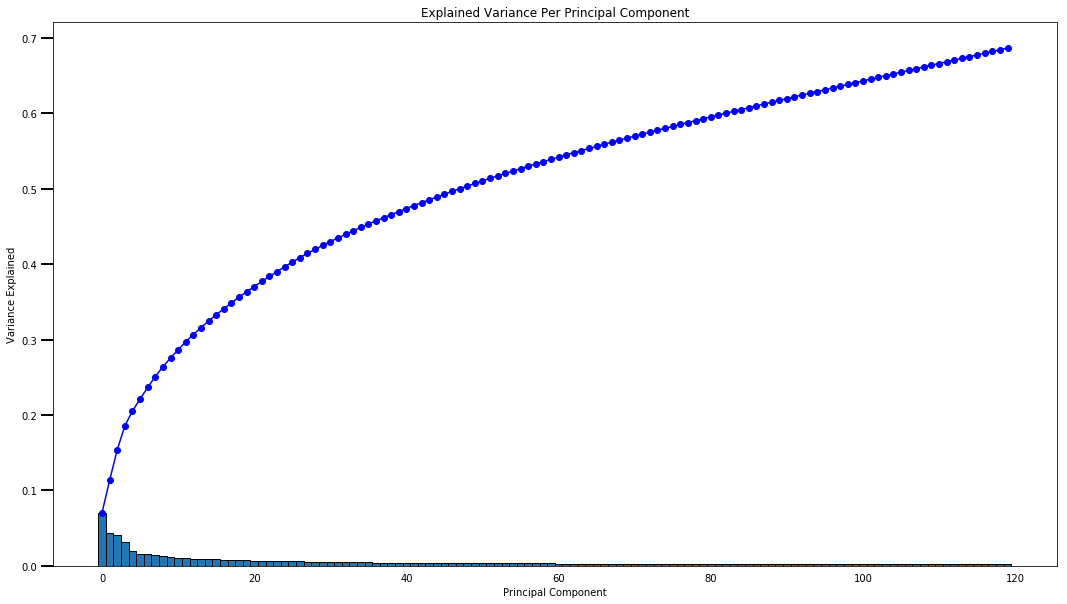

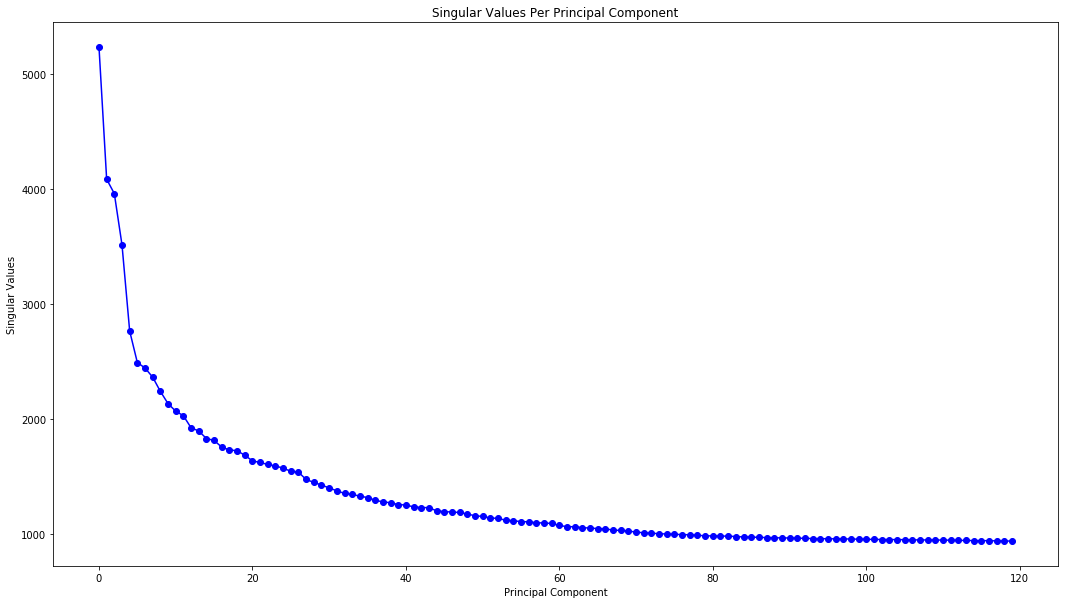

In [0]:
# Investigate the variance accounted for by each principal component

plot_pca_var(pca_azdias, 120)  # to avoid interference from too many data

* customer dataset

In [0]:
n_components =  int(len(customers_OutlierColumnRemoved_ReEncoded_scaled.columns) // 3)
pca_customers = PCA(n_components)
X_pca_customers = pca_customers.fit_transform(customers_OutlierColumnRemoved_ReEncoded_scaled)

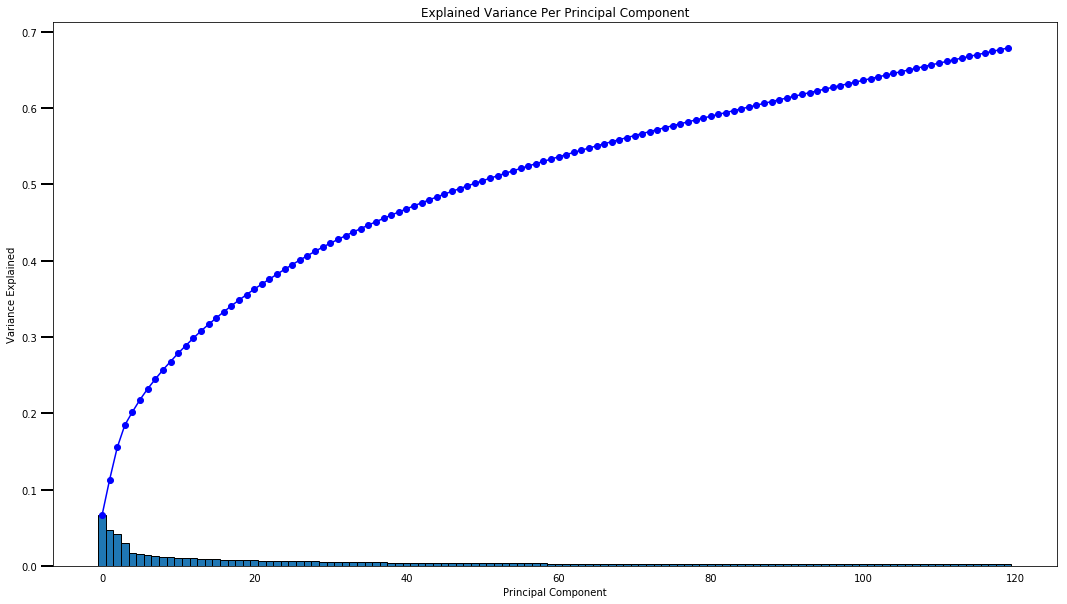

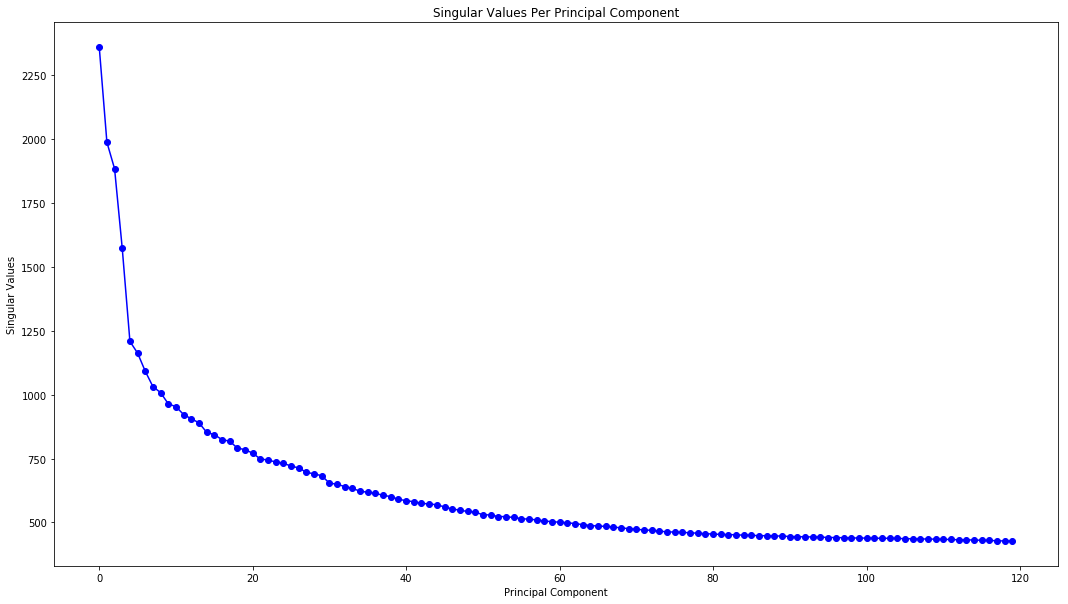

In [0]:
# Investigate the variance accounted for by each principal component

plot_pca_var(pca_customers, 120)   # to avoid interference from too many data

In [0]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = 120
pca_azdias = PCA(n_components)
X_pca_azdias = pca_azdias.fit_transform(azdias_OutlierColumnRemoved_ReEncoded_scaled)

pca_customers = PCA(n_components)
X_pca_customers = pca_customers.fit_transform(customers_OutlierColumnRemoved_ReEncoded_scaled)

**Discussion for azdias and customers data**

* Learned from figure above, i keep 120 principal components / transformed features for the next step of the analysis to maintain more than 60% variance explained and balance the compute power and accuracy.

##### **6.** Interpret Principal Components

After obtaining our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

Two explorations are applied here:
- By mapping each weight to their corresponding feature name and sorting the features according to weight, the most interesting features for each principal component are found in those at the beginning and end of the sorted list. With the help of two  data description excel files,  understand of these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate are discussed.
- To investigate and interpret feature associations from the first three principal components, a function is written to print the sorted list of feature weights, for the *i*-th principal component.

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
def plot_pca_component_weight(df, pca_instance, component_index, num):
    '''
    INPUT:
    df - a pandas dataframe containing full numerical data
    pca_instance - an instance inherited from sklearn.decomposition import PCA
    component_index - an int number deciding which component to display
    num - an int number indicating how many components to display
    
    OUTPUT:
    None - 
    
    This function plot two graphs: one is plotted to display feature weights for
    each principal component in reverse order, the other is plotted to display 
    the corresponding feature names for each principal component in reverse order.
    '''  
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_instance.components_)+1)]
    components = pd.DataFrame(np.round(pca_instance.components_, 4), columns = df.keys())
    components.index = dimensions
    ratios = pca_instance.explained_variance_ratio_.reshape(len(pca_instance.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    fig = plt.figure(figsize=(15, 10));
    ax = fig.add_subplot(111)
    component_weights = components.iloc[component_index-1, :num]
    component_weights_sorted = component_weights.sort_values(ascending=False)
    index_num = [list(df.columns).index(each) for each in component_weights_sorted.index]
    ind = np.arange(len(index_num))
    
    component_weights_sorted.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xlabel("The index of feature sorted by weight")
    ax.set_xticklabels(index_num, rotation=30)
    title_str = "Explained Variance: "\
            + str(pca_instance.explained_variance_ratio_[component_index-1])
    ax.set_title(title_str)
    
    fig2 = plt.figure(figsize=(15, 10));
    ax2 = fig2.add_subplot(111)
    component_weights_sorted.plot(ax=ax2, marker="o");
    ax2.set_xticklabels(index_num, rotation=30)
    
    for i in range(len(index_num)):
        ax2.annotate(
            "%s\n%s" % (component_weights_sorted.index[i], str(component_weights_sorted[i])), 
            (ind[i]+0.72, component_weights_sorted[i]-0.0008), 
            va="bottom",
            ha="center", 
            fontsize=12
        )
    ax2.set_ylabel("Feature Weights")
    ax2.set_xlabel("The index of feature sorted by weight")
    # ax2.set_xticklabels(index_num, rotation=30)
    
#     return index_num

* azdias dataset

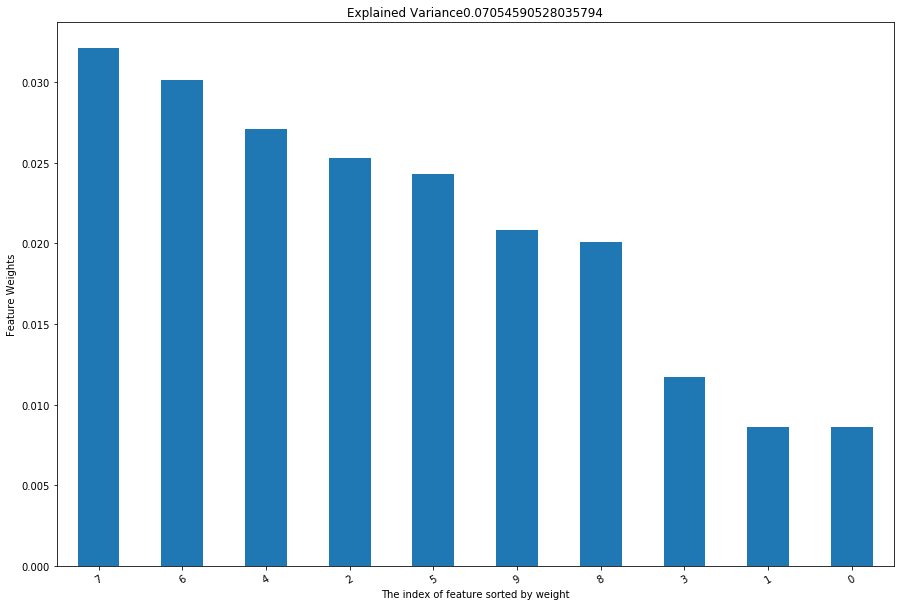

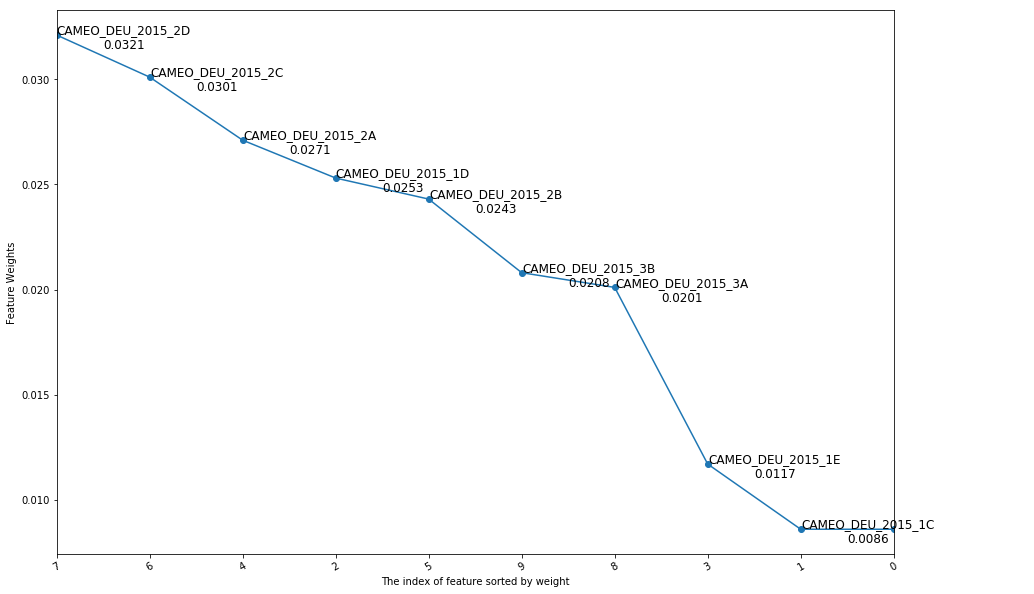

In [0]:
plot_pca_component_weight(azdias_OutlierColumnRemoved_ReEncoded_scaled, pca_azdias, 1, 10)

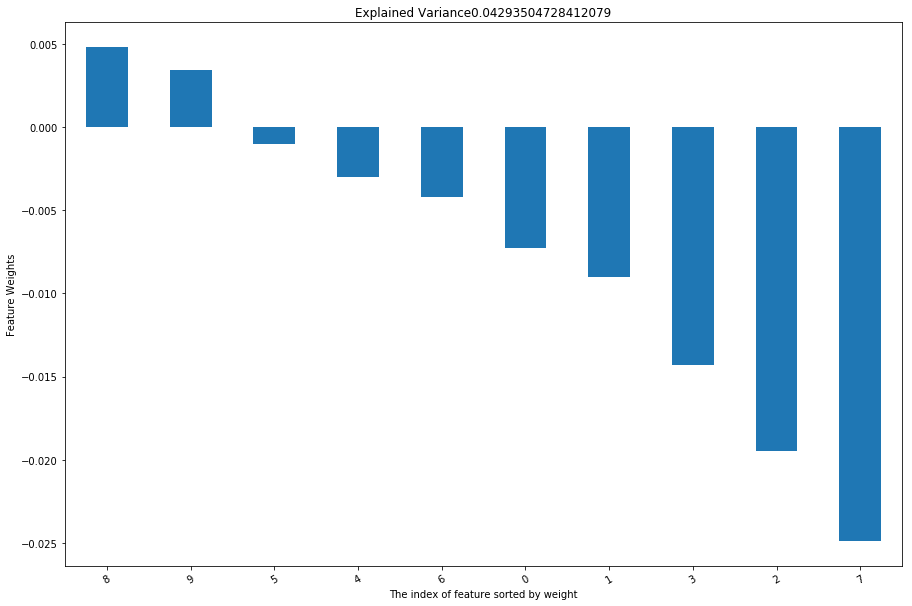

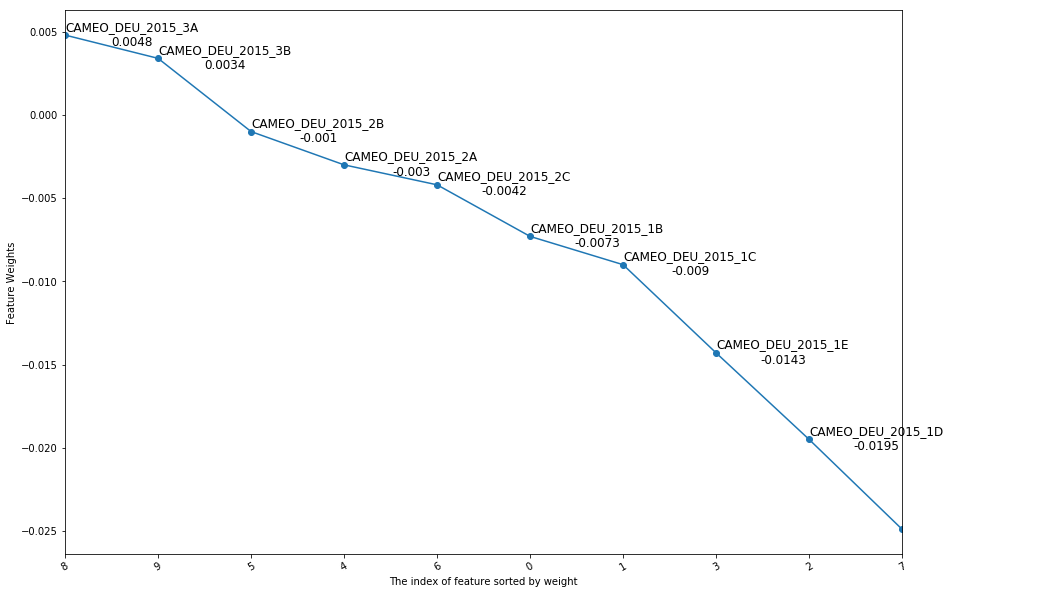

In [0]:
plot_pca_component_weight(azdias_OutlierColumnRemoved_ReEncoded_scaled, pca_azdias, 2, 10)

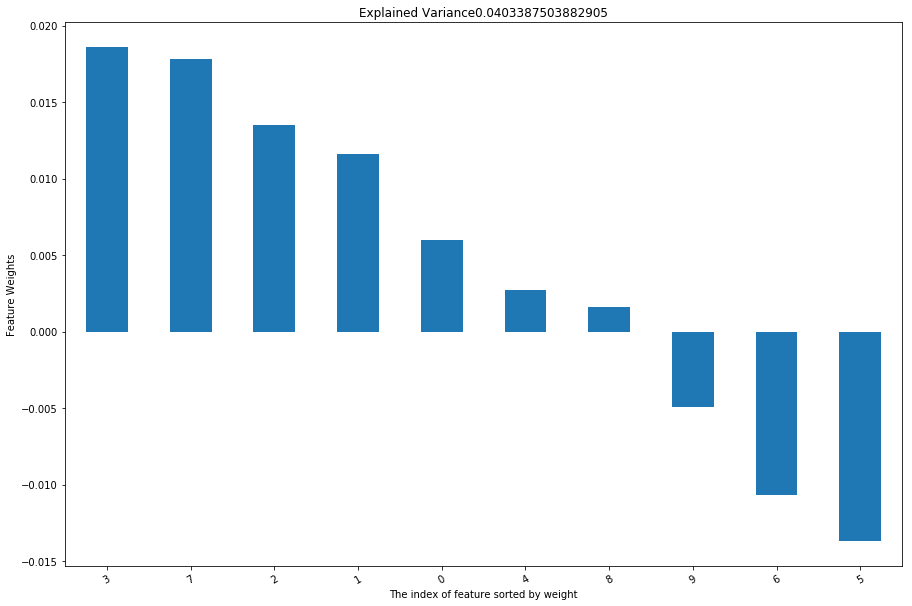

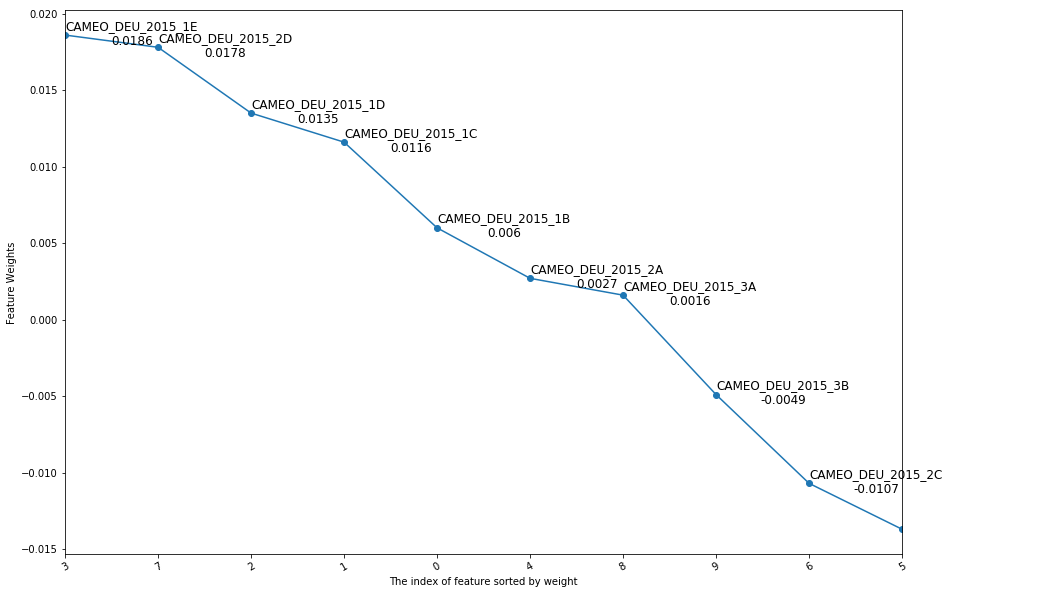

In [0]:
plot_pca_component_weight(azdias_OutlierColumnRemoved_ReEncoded_scaled, pca_azdias, 3, 10)

**Discussion for azdias data**

* For azdias data,  all positive contributed feats of the first three components come from feature "CAMEO_DEU_2015".  
* Even origining from the same feat, the most positive contributed feat of the first three components show that there is small differtence: referring to the description excel file, the first component corresponds to the *Fine Management* group, the second corresponds to the *Career & Family* group while the third corresponds to the *City Nobility* group.

* customer dataset

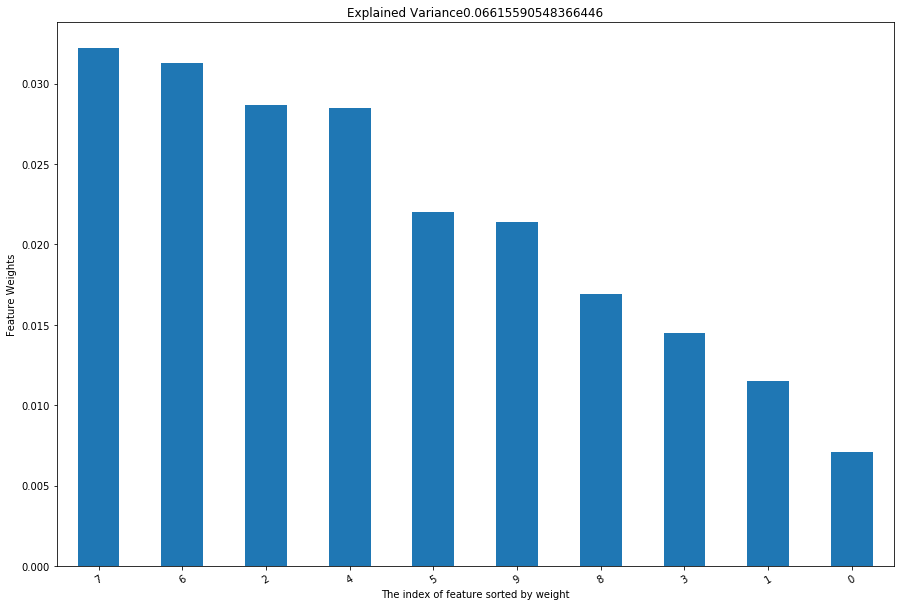

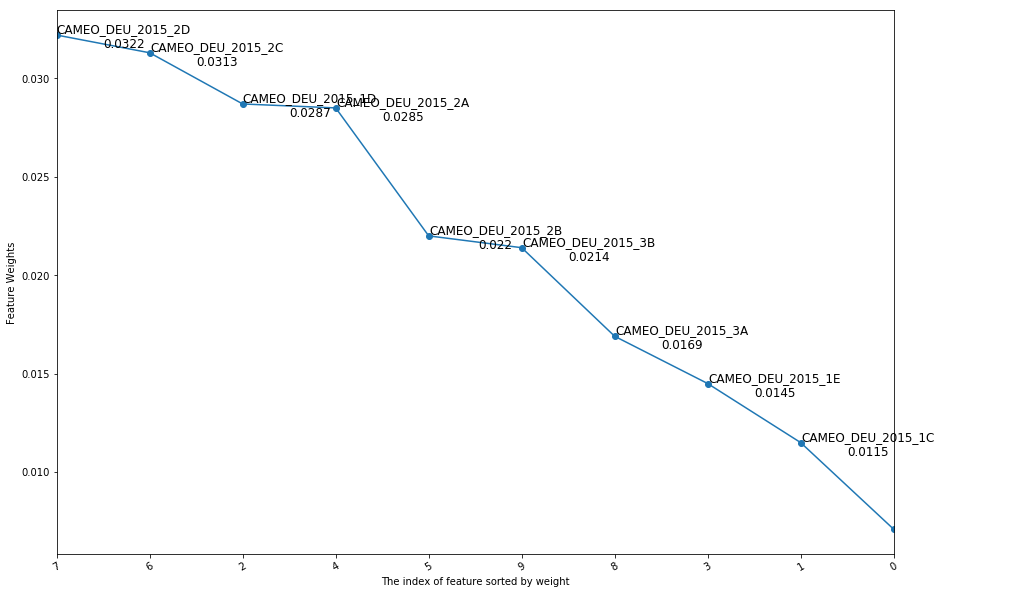

In [0]:
plot_pca_component_weight(customers_OutlierColumnRemoved_ReEncoded_scaled, pca_customers, 1, 10)

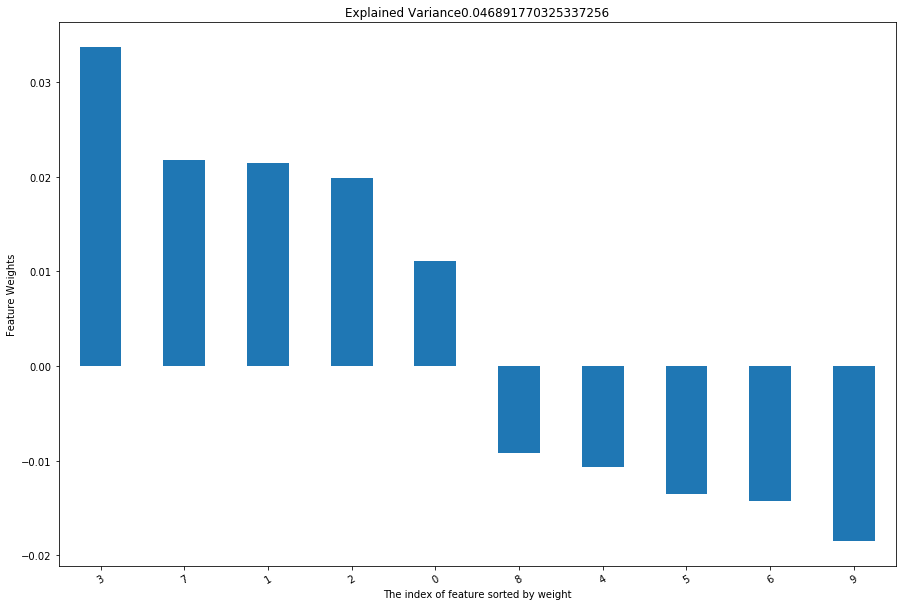

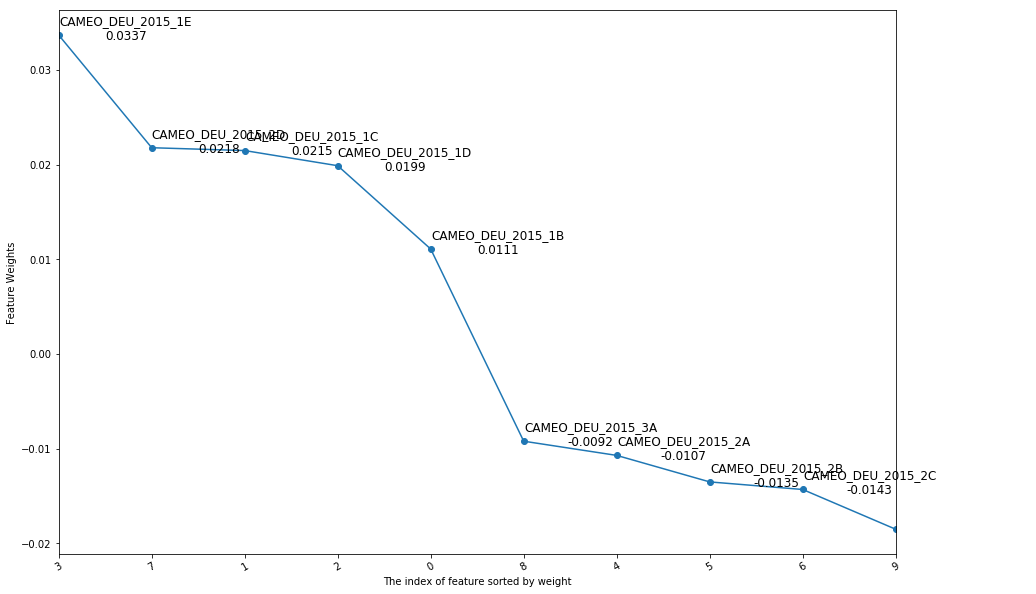

In [0]:
plot_pca_component_weight(customers_OutlierColumnRemoved_ReEncoded_scaled, pca_customers, 2, 10)

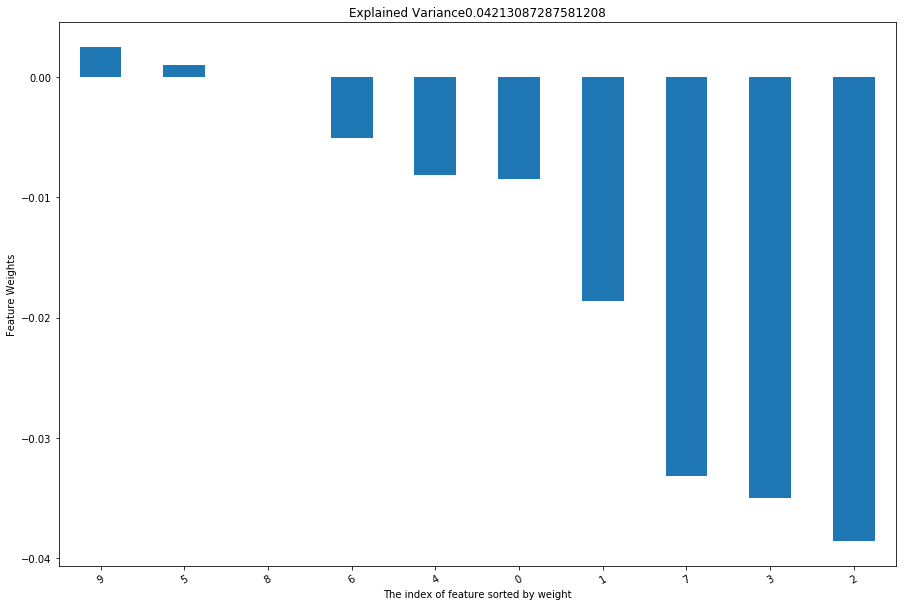

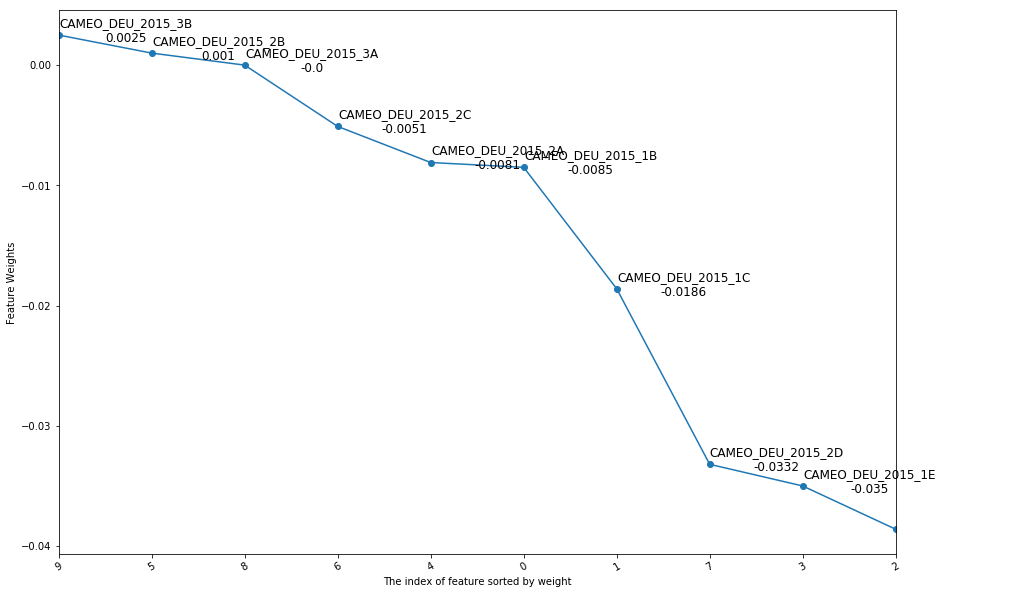

In [0]:
plot_pca_component_weight(customers_OutlierColumnRemoved_ReEncoded_scaled, pca_customers, 3, 10)

**Discussion for customers data**

* For customers data,  all positive contributed feats of the first three components come from feature "CAMEO_DEU_2015" too.  
* Even origining from the same feat, the most positive contributed feat of the first three components show that there is small differtence: referring to the description excel file, the first component corresponds to the *Fine Management* group, the second corresponds to the *City Nobility* group while the third corresponds to the *Powershopping Families* group. Compared with azdias data, both analysis of the first three components include the **Fine Management** and **City Nobility** group.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 1.1: Clustering

#### Step 1.1.1: Apply Clustering to General Population

In this substep, k-means clustering is applied to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep. In details, the operations are listed as follow:

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)  to perform k-means clustering on the PCA-transformed data.
- Compute the average difference from each point to its assigned cluster's cente  for a number of different cluster counts. 

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
def get_kmeans_score(data, center):
    '''
    INPUT:
    data - a pandas dataframe containing numerical data
    center - an int number indicating how many centers are calculated
    OUTPUT:
    None - 
    
    This function calculates the average difference from each point to its 
    assigned cluster's center to assist the choose of center number
    ''' 
    
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

* azdias dataset

In [0]:
scores = []
centers = list(range(10, 25))
for center in centers:
    print("Running kmeans by {} centers".format(center))
    scores.append(get_kmeans_score(X_pca_azdias, center))

Running kmeans by 10 centers
Running kmeans by 11 centers
Running kmeans by 12 centers
Running kmeans by 13 centers
Running kmeans by 14 centers
Running kmeans by 15 centers
Running kmeans by 16 centers
Running kmeans by 17 centers
Running kmeans by 18 centers
Running kmeans by 19 centers
Running kmeans by 20 centers
Running kmeans by 21 centers
Running kmeans by 22 centers
Running kmeans by 23 centers
Running kmeans by 24 centers


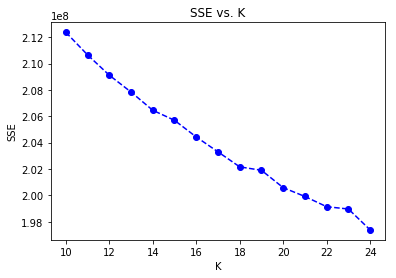

In [0]:
# Investigate the change in within-cluster distance across number of clusters

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K from 10 to 24');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [0]:
scores = []
centers = list(range(24, 35))
for center in centers:
    print("Running kmeans by {} centers".format(center))
    scores.append(get_kmeans_score(X_pca_azdias, center))

Running kmeans by 24 centers
Running kmeans by 25 centers
Running kmeans by 26 centers
Running kmeans by 27 centers
Running kmeans by 28 centers
Running kmeans by 29 centers
Running kmeans by 30 centers
Running kmeans by 31 centers
Running kmeans by 32 centers
Running kmeans by 33 centers
Running kmeans by 34 centers


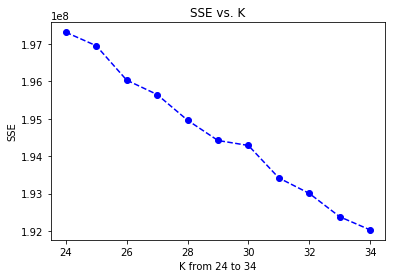

In [0]:
# Investigate the change in within-cluster distance across number of clusters

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K from 24 to 34');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the azdias data.

kmeans = KMeans(n_clusters=30)
model = kmeans.fit(X_pca_azdias)
# predict the label for azdias data
labels_azdias_pred = model.predict(X_pca_azdias)

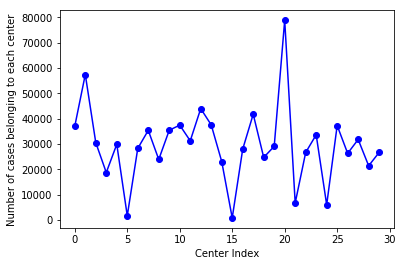

In [0]:
labels_azdias_pred_series = pd.Series(labels_azdias_pred)
counter_azdias = labels_azdias_pred_series.value_counts(sort=False)
x, y = counter.index, counter.values

plt.plot(x, y, 'bo-');
plt.xlabel('Center Index');
plt.ylabel('Number of cases belonging to each center');

* customer dataset

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the custonmers data.

kmeans = KMeans(n_clusters=30)
model = kmeans.fit(X_pca_customers)
# predict the label for customers data
labels_custo_pred = model.predict(X_pca_customers)

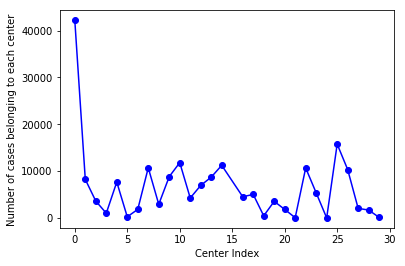

In [0]:
labels_custo_pred_series = pd.Series(labels_custo_pred)
counter_custo = labels_custo_pred_series.value_counts(sort=False)
x, y = counter.index, counter.values

plt.plot(x, y, 'bo-');
plt.xlabel('Center Index');
plt.ylabel('Number of cases belonging to each center');

**Discussion for azdias and cuustomers data**

* Here, learned from the trend of the derivative of curve above, 30 clusters are choosed to balance the computer power need with the accuracy. 

### Step 1.1.2: Compare Customer Data to Demographics Data

Ths step will compare the two cluster distributions to see where the strongest customer base for the company is by considering the proportion of persons in each cluster for the general population, and the proportions for the customers.The hint is: if we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two;  If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. In details, if there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Sub-steps are taken as follows:
- Compute the proportion of data points in each cluster for the general population and the customer data. 
- Recall the analysis performed in step 0.3.2.3 where certain data points  are separated out from the dataset if they had more than a specified threshold of missing values for both the general population and customer datasets. If it is found that this group was qualitatively different from the main bulk of the data, this should be treated as an additional data cluster in this analysis. 
- Find which cluster or clusters are overrepresented in the customer dataset compared to the general population and select such cluster to infer what kind of people might be represented by that cluster. Then, a similar investigation for the underrepresented clusters is performed to find which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters.

In [0]:
gc.collect()
sys._clear_type_cache()

In [0]:
labels_azdias_pred = np.load('labels_azdias_pred.npy')
labels_custo_pred = np.load('labels_customers_pred.npy')

labels_azdias_pred_series = pd.Series(labels_azdias_pred)
counter_azdias = labels_azdias_pred_series.value_counts(sort=False)

labels_custo_pred_series = pd.Series(labels_custo_pred)
counter_custo = labels_custo_pred_series.value_counts(sort=False)

In [0]:
x1, y1 = counter_azdias.index, counter_azdias.values
y2 = counter_custo.values

y1_ratio = 100 * (y1 / y1.sum())
y2_ratio = 100 * (y2 / y2.sum())

##### Step 1.1.2.1 compute the proportion of data points in each cluster

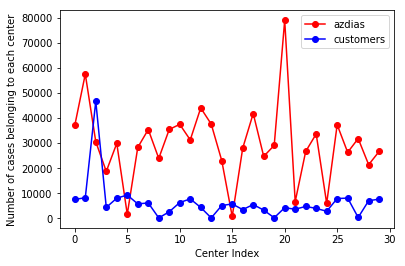

In [0]:
plt.plot(x1, y1, 'ro-', x1, y2, 'bo-');
plt.xlabel('Center Index');
plt.ylabel('Number of cases belonging to each center (%)');
plt.legend(["azdias", "customers"]);

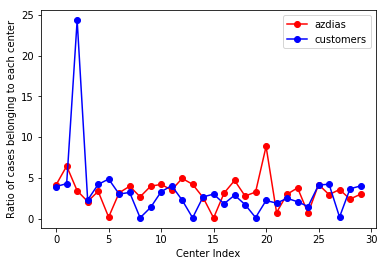

In [0]:
plt.plot(x1, y1_ratio, 'ro-', x1, y2_ratio, 'bo-');
plt.xlabel('Center Index');
plt.ylabel('Ratio of cases belonging to each center (%)');
plt.legend(["azdias", "customers"]);

##### Step 1.1.2.2 check the analysis in step 0.3.2.3

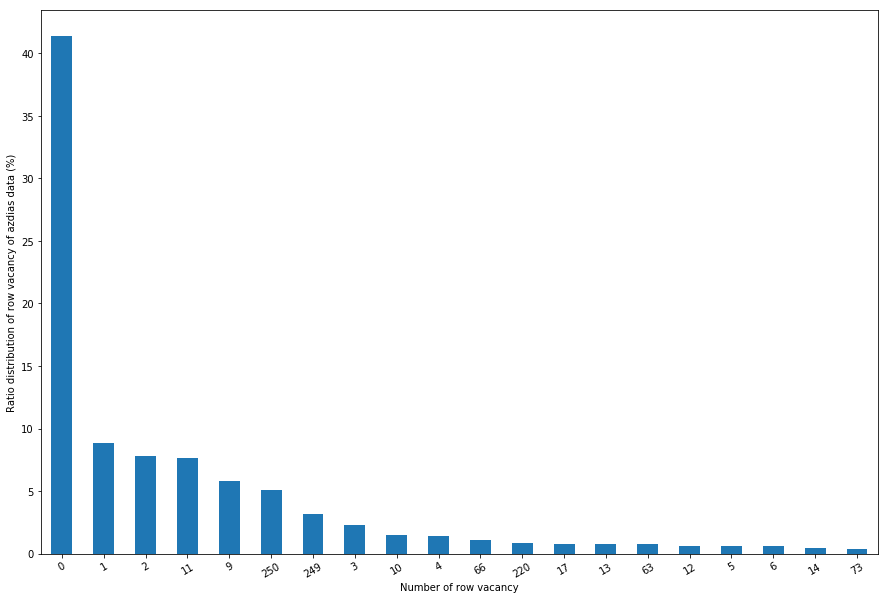

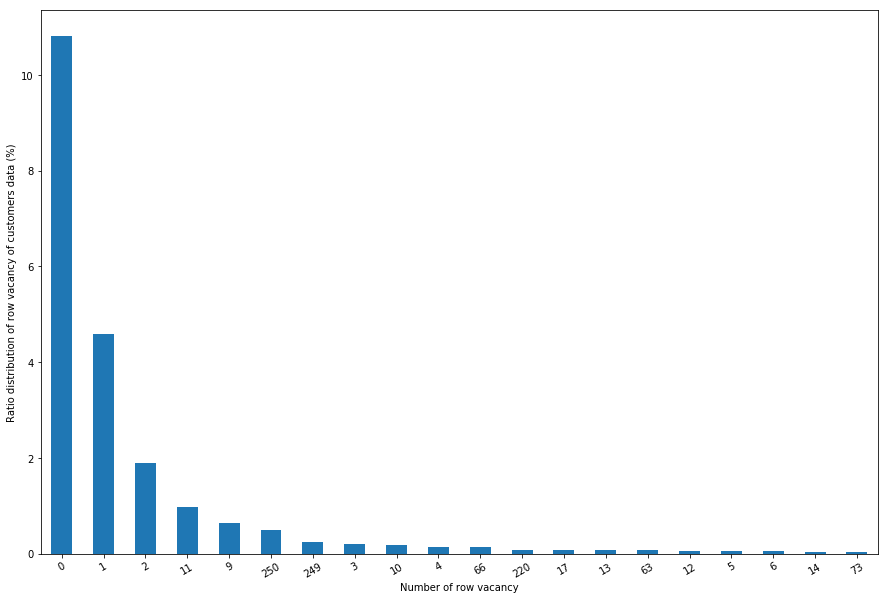

In [0]:
def cal_ratio(x):
    '''
    INPUT:
    x - a pandas series parased by apply attribute
    
    OUTPUT:
     - 
    
    This function will calculate the ratio (unit, %) of specified x to total count number
    '''
    
    return (100 * x / azdias_row_vacancy_asses_series.shape[0])


azdias_row_vacancy_asses_series = pd.Series(azdias_row_vacancy_asses)
customers_row_vacancy_asses_series = pd.Series(customers_row_vacancy_asses)

fig = plt.figure(figsize=(15, 10));
ax = fig.add_subplot(111)
data_azdias = azdias_row_vacancy_asses_series.value_counts()
data_azdias_ratio = data_azdias.apply(cal_ratio)
data_azdias_ratio[:20].plot(ax=ax, kind='bar');
ax.set_ylabel("Ratio distribution of row vacancy of azdias data (%)");
ax.set_xlabel("Number of row vacancy");
ax.set_xticklabels(data_azdias.index, rotation=30);

fig2 = plt.figure(figsize=(15, 10));
ax2 = fig2.add_subplot(111)
data_custo = customers_row_vacancy_asses_series.value_counts()
data_custo_ratio = data_custo.apply(cal_ratio)
data_custo_ratio[:20].plot(ax=ax2, kind='bar');
ax2.set_ylabel("Ratio distribution of row vacancy of customers data (%)");
ax2.set_xlabel("Number of row vacancy");
ax2.set_xticklabels(data_azdias.index, rotation=30);

In [0]:
row_vacancy_ave_azdias = azdias_row_vacancy_asses.mean()
row_vacancy_ave_customers = customers_row_vacancy_asses.mean()
ratio_azdias_low = 100 * (azdias_OutlierColumnRemoved_low.shape[0] / azdias_OutlierColumnRemoved.shape[0])
ratio_azdias_high = 100 * (azdias_OutlierColumnRemoved_high.shape[0] / azdias_OutlierColumnRemoved.shape[0])
ratio_customers_low = 100 * (customers_OutlierColumnRemoved_low.shape[0] / customers_OutlierColumnRemoved.shape[0])
ratio_customers_high = 100 * (customers_OutlierColumnRemoved_high.shape[0] / customers_OutlierColumnRemoved.shape[0])

print(
    "For azdias data, the average vacancy is {}. In details, there is {}% low vacancy data while {}% high vacancy data"
        .format(row_vacancy_ave_azdias, ratio_azdias_low, ratio_azdias_high))
print(
    "For customers data, the average vacancy is {}. In details, there is {}% low vacancy data while {}% high vacancy data"
        .format(row_vacancy_ave_customers, ratio_customers_low, ratio_customers_high))      

For azdias data, the average vacancy is 34.064179367407185. In details, there is 82.71573492994443% low vacancy data while 17.284265070055575% high vacancy data
For customers data, the average vacancy is 68.62456953227725. In details, there is 72.52572370755327% low vacancy data while 27.474276292446724% high vacancy data


In [0]:
# create a new cluster for all data

is_high_vacancy_azdias = (azdias_row_vacancy_asses > row_vacancy_ave_azdias)
is_high_vacancy_customers = (customers_row_vacancy_asses > row_vacancy_ave_customers)

In [0]:
# np.save('is_high_vacancy_azdias.npy', is_high_vacancy_azdias)
# np.save('is_high_vacancy_customers.npy', is_high_vacancy_customers)

is_high_vacancy_azdias = np.load('is_high_vacancy_azdias.npy')
is_high_vacancy_customers = np.load('is_high_vacancy_customers.npy')

##### Step 1.1.2.3 find overrepresented and underrepresented people group

In [0]:
def count_column_ratio(x):
    '''
    INPUT:
    x - a pandas series parased by apply attribute
    
    OUTPUT:
    ratio - a int number indicating the largest distribution ratio within one column
    
    This function will calculate the largest count ratio 
    (largest count number seperated by least count number) within one feature column.
    '''
      
    counter = x.value_counts()
    ratio = counter.max() / counter.min()
    
    return ratio

In [0]:
# compare all clusters in two datasets

# clusters by kmeans
cluster_overrepresented_index = x1[y1_ratio < y2_ratio]
cluster_underrepresented_index = x1[y1_ratio > y2_ratio]
print(
    "The clusters that is overrepresented in the customer data compared to the general population include {}".format(cluster_overrepresented_index))
print(
    "The clusters that is underrepresented in the customer data compared to the general population include {}".format(cluster_underrepresented_index))
# clusters by row vacancy
if is_high_vacancy_azdias.sum() > is_high_vacancy_customers.sum():
    print(
    "The cluster of whether vacancy of data exceeds the average row vacancy or not belongs to overrepresented cluster")
else:
     print(
    "The cluster of whether vacancy of data exceeds the average row vacancy or not belongs to underrepresented cluster")   

The clusters that is overrepresented in the customer data compared to the general population include Int64Index([2, 3, 4, 5, 11, 14, 15, 21, 24, 26, 28, 29], dtype='int64')
The clusters that is underrepresented in the customer data compared to the general population include Int64Index([0, 1, 6, 7, 8, 9, 10, 12, 13, 16, 17, 18, 19, 20, 22, 23, 25, 27], dtype='int64')
The cluster of whether vacancy of data exceeds the average row vacancy or not belongs to overrepresented cluster


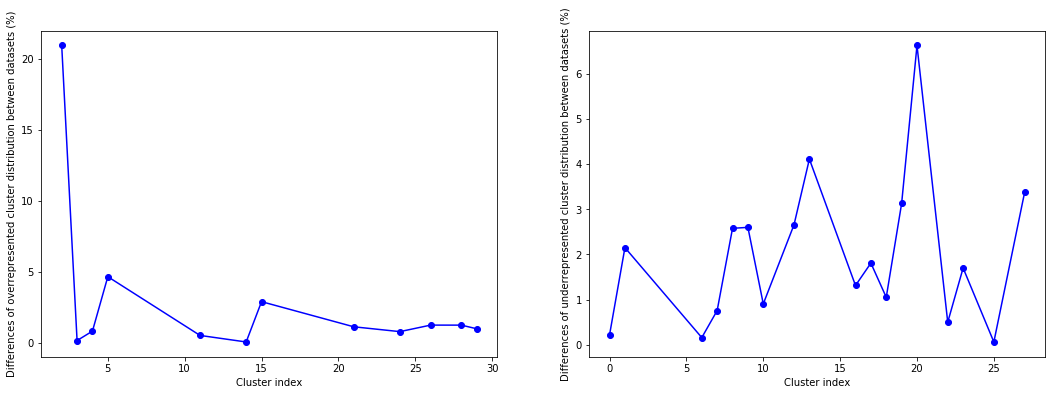

In [0]:
diff1 = (y2_ratio - y1_ratio)[cluster_overrepresented_index]
diff2 = (y1_ratio - y2_ratio)[cluster_underrepresented_index]

fig = plt.figure(figsize=(18, 6));
ax1 = fig.add_subplot(121)
ax1.plot(cluster_overrepresented_index, diff1, 'bo-');
ax1.set_xlabel('Cluster index');
ax1.set_ylabel('Differences of overrepresented cluster distribution between datasets (%)');

ax2 = fig.add_subplot(122)
ax2.plot(cluster_underrepresented_index, diff2, 'bo-');
ax2.set_xlabel('Cluster index');
ax2.set_ylabel('Differences of underrepresented cluster distribution between datasets (%)');

In [0]:
cluster_overrepresented_index[diff1 > 4]

Int64Index([2, 5], dtype='int64')

In [0]:
cluster_underrepresented_index[diff2 > 4]

Int64Index([13, 20], dtype='int64')

In [0]:
# find what kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population

# check cluster with difference near 4%
feat_azdias, feat_custo = [], []
cluster_index_over = cluster_overrepresented_index[diff1 > 4]

for ind in cluster_index_over:
    group1_azdias = azdias_OutlierColumnRemoved_ReEncoded.loc[
        labels_azdias_pred_series[labels_azdias_pred_series == ind].index, :]
    group1_custo = customers_OutlierColumnRemoved_ReEncoded.loc[
        labels_custo_pred_series[labels_custo_pred_series == ind].index, :]
    ratio_azdias = group1_azdias.apply(count_column_ratio, axis=0)
    ratio_customers = group1_custo.apply(count_column_ratio, axis=0)
    
    ratio_azdias.sort_values(ascending=False, inplace=True)
    ratio_customers.sort_values(ascending=False, inplace=True)
    
    print("For cluster that is overrepresented in the customer data compared to the general population: ")
    print("The five features with most obvious feature distribution in cluster {} for azdias data is {}".format(ind, list(ratio_azdias.index[:5])))
    print("The five features with most obvious feature distribution in cluster {} for customers data is {}".format(ind, list(ratio_customers.index[:5]) ))
    print("\n")
    
    feat_azdias += list(ratio_azdias.index[:5])
    feat_custo += list(ratio_customers.index[:5]) 
    
    del group1_azdias
    del group1_custo
    del ratio_azdias
    del ratio_customers

For cluster that is overrepresented in the customer data compared to the general population: 
The five features with most obvious feature distribution in cluster 2 for azdias data is ['D19_BANKEN_OFFLINE_DATUM', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_LEBENSMITTEL', 'ANZ_HH_TITEL']
The five features with most obvious feature distribution in cluster 2 for customers data is ['CAMEO_DEU_2015_9A', 'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT', 'CAMEO_DEU_2015_5F', 'CAMEO_DEU_2015_6C', 'CAMEO_DEU_2015_6F']


For cluster that is overrepresented in the customer data compared to the general population: 
The five features with most obvious feature distribution in cluster 5 for azdias data is ['D19_TELKO_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE_D19_LOTTO', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_NAHRUNGSERGAENZUNG']
The five features with most obvious feature distribution in cluster 5 for customers data is ['D19_BANKEN_OFFLINE_DATUM', 'ANZ_KINDER', 'D19_DIGIT_SERV

In [0]:
# output most obvious features for two overrepresented clusters

[each_feat if each_feat not in feat_azdias else None for each_feat in feat_custo]

['CAMEO_DEU_2015_9A',
 'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
 'CAMEO_DEU_2015_5F',
 'CAMEO_DEU_2015_6C',
 'CAMEO_DEU_2015_6F',
 None,
 'ANZ_KINDER',
 'D19_DIGIT_SERV',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_12']

In [0]:
# find what kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population

# check cluster with difference near 5%
feat_azdias, feat_custo = [], []
cluster_index_under = cluster_underrepresented_index[diff2 > 4]

for ind in cluster_index_under:
    group1_azdias = azdias_OutlierColumnRemoved_ReEncoded.loc[
        labels_azdias_pred_series[labels_azdias_pred_series == ind].index, :]
    group1_custo = customers_OutlierColumnRemoved_ReEncoded.loc[
        labels_custo_pred_series[labels_custo_pred_series == ind].index, :]
    ratio_azdias = group1_azdias.apply(count_column_ratio, axis=0)
    ratio_customers = group1_custo.apply(count_column_ratio, axis=0)
    
    ratio_azdias.sort_values(ascending=False, inplace=True)
    ratio_customers.sort_values(ascending=False, inplace=True)
    
    print("For cluster that is underrepresented in the customer data compared to the general population: ")
    print("The five features with most obvious feature distribution in cluster {} for azdias data is {}".format(ind, list(ratio_azdias.index[:5])))
    print("The five features with most obvious feature distribution in cluster {} for customers data is {}".format(ind, list(ratio_customers.index[:5])))
    print("\n")
      
    feat_azdias += list(ratio_azdias.index[:5])
    feat_custo += list(ratio_customers.index[:5]) 
    
    del group1_azdias
    del group1_custo
    del ratio_azdias
    del ratio_customers

For cluster that is underrepresented in the customer data compared to the general population: 
The five features with most obvious feature distribution in cluster 13 for azdias data is ['ANZ_TITEL', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12', 'D19_GARTEN']
The five features with most obvious feature distribution in cluster 13 for customers data is ['CAMEO_DEU_2015_6E', 'CAMEO_DEU_2015_6F', 'D19_VERSI_ONLINE_DATUM', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_7E']


For cluster that is underrepresented in the customer data compared to the general population: 
The five features with most obvious feature distribution in cluster 20 for azdias data is ['D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG', 'D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK', 'D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK', 'D19_BANKEN_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM']
The five features with most obvious feature distribution in cluster 20 for customers data is ['CAMEO_DEU_2015_2C', 'CAMEO_DEU_2015_3A', 'CAMEO_D

In [0]:
# output most obvious features for two underrepresented  clusters

[each_feat if each_feat not in feat_custo else None for each_feat in feat_azdias]

['ANZ_TITEL',
 'D19_TELKO_ONLINE_DATUM',
 None,
 'D19_BANKEN_ANZ_12',
 'D19_GARTEN',
 'D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG',
 'D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK',
 'D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK',
 None,
 None]

**Discussion for azdias and customers data**

* As it is shown above, the cluster of vacancy of data exceeds the average row vacancy or not shows an obvious difference between general azdias data and customers data. Meanwhile, by deep investigation, belongs to overrepresented cluster, which means that customers data is more likely to have higher row vacancy. 
* Besides row vacancy cluster, two representative clusters for overrepresented cluster type and two for underrepresented cluster type are captured respectively. For overrepresented cluster type, cluster 2  and 5 show that people with **Active Retirement("CAMEO_DEU_2015_5F")**, **Long-established("CAMEO_DEU_2015_6C")**, **Frugal Aging("CAMEO_DEU_2015_6F")**, and **First Shared Apartment("CAMEO_DEU_2015_9A")** or high transactional activity on **product group DIGITAL SERVICES("D19_DIGIT_SERV_RZ")**,  **BANKS in the last 24 months("D19_BANKEN_ANZ_24")** and **INSURANCE in the last 12 months("D19_VERSI_ANZ_12")** are more likely to become customer.
* However, for underrepresented cluster type,  cluster 13 and cluster 20 show that people with high transactional activity on **the last transaction for the segment telecommunication ONLINE("D19_TELKO_ONLINE_DATUM")**, **BANKS in the last 12 months("D19_BANKEN_ANZ_12")** and **the product group GARDENING PRODUCTS("D19_GARTEN")** are less likely to become customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [25]:
def display_importances(feature_importance_df_):
    '''  
    INPUT:  
    feature_importance_df_ - a pandas dataframe containing importance analysis by 
                                                LightGBM model
    
    OUTPUT: 
    best_features - a pandas series indicating best features used by LighGBM model
    
    This fuction will plot the feature importance for trained LIghtGBM model and return 
    the best features of this model.
    '''
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    
    return best_features

In [18]:
gc.collect()
sys._clear_type_cache()

In [17]:
def clean_data(df):
    '''  
    INPUT:  
    df - a pandas dataframe including azdias or customers raw data
    
    OUTPUT: 
    df_ori_OutlierColumnRemoved_ReEncoded_scaled - a pandas dataframe with trimmed and cleaned data
    
    This fuction will perform feature trimming, re-encoding, and engineering for raw data.
    '''
    
    df_ori = copy.copy(df)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_ori_noUnknown = replace_unkown(df_ori, map_unknown_df)
    

    # remove selected columns and rows, ...
    df_ori_noUnknown_column_vacancy_asses = df_ori_noUnknown.isnull().mean()
    df_ori_noUnknown_feats, df_ori_noUnknown_column_vacancy = \
        df_ori_noUnknown_column_vacancy_asses.index, df_ori_noUnknown_column_vacancy_asses.values
    remove_list = \
        [
            np.where(df_ori_noUnknown_column_vacancy == each_num)[0][0] 
                 for each_num in df_ori_noUnknown_column_vacancy[df_ori_noUnknown_column_vacancy > 0.4]
        ]
    df_ori_OutlierColumnRemoved = df_ori_noUnknown.drop(df_ori_noUnknown_feats[remove_list], axis=1)       
        
    # select, re-encode, and engineer column values.    
    # deal with not-recorded unkown features
    df_ori_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].replace("X", np.nan, inplace=True)
    df_ori_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"] = \
        df_ori_OutlierColumnRemoved.loc[:, "CAMEO_DEUG_2015"].astype("float")
    df_ori_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].replace("XX", np.nan, inplace=True)
    df_ori_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"] = \
        df_ori_OutlierColumnRemoved.loc[:, "CAMEO_INTL_2015"].astype("float")

    # classify categorical features
    df_feat_types = df_ori_OutlierColumnRemoved.dtypes
    df_categ = df_feat_types[df_feat_types == "object"]
    df_ori_OutlierColumnRemoved_categorical = df_ori_OutlierColumnRemoved.loc[:, df_categ.index]
    feats_binary, feats_multi = [], []
    # divide all categorical features into binary and multi-class features
    for each_feat in df_categ.index:
        temp = set(df_ori_OutlierColumnRemoved_categorical[each_feat].dropna().values)
        if len(temp) == 2:
            feats_binary.append(each_feat)
        else:
            feats_multi.append(each_feat)
    del df_ori_OutlierColumnRemoved_categorical

    gc.collect()
    sys._clear_type_cache()

    # re-encode for binary features
    for feat in feats_binary:
        temp = df_ori_OutlierColumnRemoved.loc[:, feat]    
        vals = list(set(temp.dropna().values))
        map_dict = {vals[0]: 0, vals[1]:1}
        df_ori_OutlierColumnRemoved.loc[:, feat] = \
            temp.map(map_dict)   
        del temp

    # re-encode for multi-class features
    # deal with the datetime data
    feats_multi.remove("EINGEFUEGT_AM")
    df_ori_OutlierColumnRemoved_date_series = \
        pd.DataFrame(
            pd.to_datetime(df_ori_OutlierColumnRemoved.loc[:, "EINGEFUEGT_AM"])
        )
    df_ori_OutlierColumnRemoved_date_series["Year"] = \
        df_ori_OutlierColumnRemoved_date_series["EINGEFUEGT_AM"].apply(lambda x: x.year)
    temp = df_ori_OutlierColumnRemoved_date_series["Year"]
    global century_min
    century_max, century_min = \
        int(temp.max() // 100 + 1), int(temp.min() // 100 + 1)      
    df_ori_OutlierColumnRemoved_date_series["Century"] = \
        df_ori_OutlierColumnRemoved_date_series["Year"].apply(convert_to_century)
    del temp
    temp = pd.get_dummies(df_ori_OutlierColumnRemoved_date_series["Century"])
    names = ["Century_"+str(val)+"'s" for val in range(century_min, century_max+1)]
    temp.columns = names
    df_ori_OutlierColumnRemoved = \
        pd.concat(
            [df_ori_OutlierColumnRemoved, temp], axis=1
        )
    del century_min
    del df_ori_OutlierColumnRemoved_date_series
    # deal with the left muti-class data
    df_ori_OutlierColumnRemoved_feats = df_ori_OutlierColumnRemoved.columns
    feats_multi = np.array(feats_multi)
    feats_all = np.array(df_ori_OutlierColumnRemoved_feats)
    feats_all_nomulti = \
        np.delete(
            feats_all, 
            [np.where(feats_all == each_feat)[0][0] for each_feat in feats_multi]
        )
    df_ori_OutlierColumnRemoved_remain = df_ori_OutlierColumnRemoved[feats_all_nomulti][:]
    df_ori_OutlierColumnRemoved_ReEncoded_multi = \
        pd.get_dummies(df_ori_OutlierColumnRemoved[feats_multi], drop_first=True)
    df_ori_OutlierColumnRemoved_ReEncoded = \
        pd.concat(
            [df_ori_OutlierColumnRemoved_ReEncoded_multi,df_ori_OutlierColumnRemoved_remain], axis=1
        )
    del df_ori_OutlierColumnRemoved_remain
    del df_ori_OutlierColumnRemoved_ReEncoded_multi

    gc.collect()
    sys._clear_type_cache()

    # engineer mixed-type features
    # try to find mixed features
    part = \
        feat_map_info[feat_map_info["Attribute"]\
                      .isin(df_ori_OutlierColumnRemoved.columns)]
    index =[]
    for item in part["Meaning"].values:
        if 'float' in str(type(item)):
            index.append(False) 
        elif "+" in item or "mixed" in item:
            index.append(True) 
        else:
            index.append(False)     
    mixed_features_list = list(set(part.loc[index, "Attribute"]))
    print("Found mixed features listed as: {}".format(mixed_features_list))
    # by manual checking from "DIAS Information Levels - Attributes 2017.xlsx", drop false mixed features 
    try:
        mixed_features_list.remove("GEBAEUDETYP_RASTER")
    except ValueError:
        pass
    else:
        try:
            mixed_features_list.remove("GEBAEUDETYP")   
        except ValueError:
            pass    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    PRAEGENDE_JUGENDJAHRE_divided = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] 
    ruler = \
        {1:[40, 1], 
         2:[40, 0], 
         3:[50, 1], 
         4:[50, 0], 
         5:[60, 1], 
         6:[60, 0], 
         7:[60, 0], 
         8:[70, 1], 
         9:[70, 0], 
         10:[80, 1], 
         11:[80, 0], 
         12:[80, 1], 
         13:[80, 0], 
         14:[90, 1], 
         15:[90, 0]}
    data = df_ori_OutlierColumnRemoved_ReEncoded["PRAEGENDE_JUGENDJAHRE"].map(ruler)
    df_ori_OutlierColumnRemoved_ReEncoded.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)
    data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
    PRAEGENDE_JUGENDJAHRE_divided_df = \
        pd.DataFrame(
            data=[np.array(each_value).squeeze() for each_value in data], 
            columns=PRAEGENDE_JUGENDJAHRE_divided
        )
    df_ori_OutlierColumnRemoved_ReEncoded = \
        pd.concat(
        [
             df_ori_OutlierColumnRemoved_ReEncoded, 
             PRAEGENDE_JUGENDJAHRE_divided_df
        ],
        axis=1) 
    del PRAEGENDE_JUGENDJAHRE_divided_df
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    CAMEO_INTL_2015_divided = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
    
    data = \
        df_ori_OutlierColumnRemoved_ReEncoded["CAMEO_INTL_2015"]\
            .astype('float')\
            .map(lambda x: [x//10, x%10])
    df_ori_OutlierColumnRemoved_ReEncoded.drop(["CAMEO_INTL_2015"], axis=1, inplace=True)
    data[data.isnull()] = data[data.isnull()].apply(lambda x: [np.nan, np.nan])
    CAMEO_INTL_2015_divided_df = \
        pd.DataFrame(
            data=[np.array(each_value).squeeze() for each_value in data], 
            columns=CAMEO_INTL_2015_divided
        )
    df_ori_OutlierColumnRemoved_ReEncoded = \
        pd.concat(
        [
            df_ori_OutlierColumnRemoved_ReEncoded, 
            CAMEO_INTL_2015_divided_df
        ], 
        axis=1)
    del CAMEO_INTL_2015_divided_df
    try:
        df_ori_OutlierColumnRemoved_ReEncoded.drop(["EINGEFUEGT_AM"], axis=1, inplace=True)
    except KeyError:
        pass
    else:
        try:
            df_ori_OutlierColumnRemoved_ReEncoded.drop(["PRODUCT_GROUP_COSMETIC_AND_FOOD"], axis=1, inplace=True)
        except KeyError:
            pass

    gc.collect()
    sys._clear_type_cache()

    # feature scaling
    filler_vacancy = Imputer()
    df_ori_OutlierColumnRemoved_ReEncoded_nonull = \
        pd.DataFrame(
            data=filler_vacancy.fit_transform(df_ori_OutlierColumnRemoved_ReEncoded),
            columns=df_ori_OutlierColumnRemoved_ReEncoded.columns)
    del df_ori_OutlierColumnRemoved_ReEncoded
    scaler_std = StandardScaler()
    df_ori_OutlierColumnRemoved_ReEncoded_scaled = \
        pd.DataFrame(
            data=scaler_std.fit_transform(df_ori_OutlierColumnRemoved_ReEncoded_nonull),
            columns=df_ori_OutlierColumnRemoved_ReEncoded_nonull.columns)
    del df_ori_OutlierColumnRemoved_ReEncoded_nonull

    gc.collect()
    sys._clear_type_cache()    
    
    # Return the cleaned dataframe.
    return df_ori_OutlierColumnRemoved_ReEncoded_scaled

In [4]:
train_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 27.86 Mb (76.8% reduction)
Mem. usage decreased to 27.74 Mb (76.8% reduction)


In [7]:
target = train_df['RESPONSE']
target.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [19]:
train_df = clean_data(train_df)
test_df = clean_data(test_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True
Found mixed features listed as: ['GEBAEUDETYP_RASTER', 'PRAEGENDE_JUGENDJAHRE', 'GEBAEUDETYP']
True
Found mixed features listed as: ['GEBAEUDETYP_RASTER', 'PRAEGENDE_JUGENDJAHRE', 'GEBAEUDETYP']


In [20]:
# select features by the above discussions

abandoned_list = \
    [
        "D19_BANKEN_OFFLINE_DATUM",
        "D19_VERSI_ONLINE_DATUM", 
        "D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT",
        "D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG",
        "D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK",
        "D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK"]

features = []
for col in list(test_df.columns):
    if col not in abandoned_list:
        features.append(col)

In [21]:
params = {
          'boosting_type': 'rf',
          'metric': 'auc',
          'num_leaves': 70, 
          'max_depth': 5,
          'learning_rate': 0.008,
          'n_estimators': 150,
          'subsample_for_bin': 200000,
          'objective': 'binary',
          'class_weight': None,
          'min_split_gain': 0,
          'min_child_weight': 0,
          'min_child_samples': 35,
          'subsample': 1,
          'subsample_freq': 0,
          'colsample_bytree': 1,
          'reg_alpha': 0.11,  # L1 reg
          'reg_lambda': 0.5,  # L2 reg
          'random_state': 23,
          'n_jobs': 3,
          'silent': False,
          'importance_type': 'split',
            
          "feature_fraction": 0.85,
          "bagging_freq": 1,
          "bagging_fraction": 0.82,
          "bagging_seed": 42,
          "metric_freq": 200,
#           "early_stopping_round": 150,
          "num_iterations": 10000,
          "is_unbalance": True,  # used only in `binary` application
         
          "num_class": 1
         }

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_df, target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=10, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.850072	valid_1's auc: 0.7399
[20]	training's auc: 0.851546	valid_1's auc: 0.736936
[30]	training's auc: 0.852249	valid_1's auc: 0.740666
[40]	training's auc: 0.851797	valid_1's auc: 0.743036
[50]	training's auc: 0.850187	valid_1's auc: 0.743597
[60]	training's auc: 0.850855	valid_1's auc: 0.741498
[70]	training's auc: 0.851024	valid_1's auc: 0.740492
[80]	training's auc: 0.851139	valid_1's auc: 0.738642
[90]	training's auc: 0.851069	valid_1's auc: 0.739436
[100]	training's auc: 0.852601	valid_1's auc: 0.736648
[110]	training's auc: 0.853805	valid_1's auc: 0.735893
[120]	training's auc: 0.85439	valid_1's auc: 0.734894
[130]	training's auc: 0.854716	valid_1's auc: 0.735286
[140]	training's auc: 0.854701	valid_1's auc: 0.735228
[150]	training's auc: 0.855763	valid_1's auc: 0.734265
Early stopping, best iteration is:
[54]	training's auc: 0.850887	valid_1's auc: 0.744014
fold n°1
Training until validation 

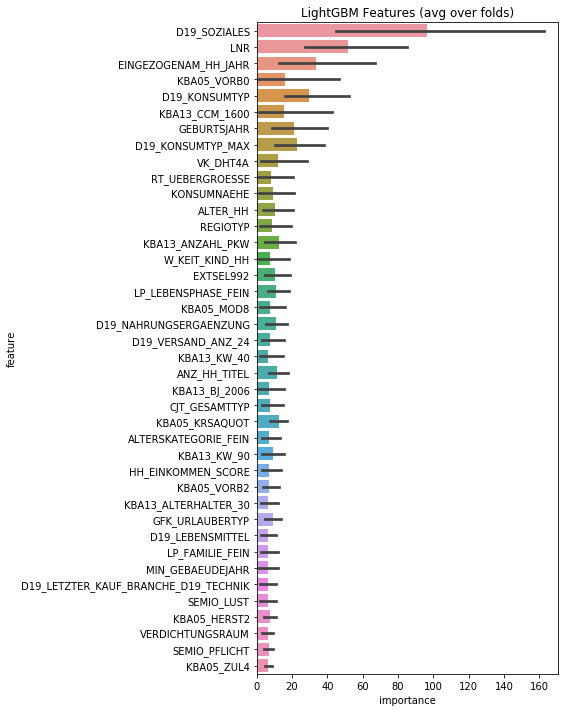

In [26]:
best_features = display_importances(feature_importance_df)

In [36]:
best_features.sort_values(by="importance", ascending=False)

,feature,importance,fold
134,D19_SOZIALES,230,2
74,LNR,112,2
134,D19_SOZIALES,108,1
161,EINGEZOGENAM_HH_JAHR,96,2
239,KBA05_VORB0,77,2
123,D19_KONSUMTYP,73,2
271,KBA13_CCM_1600,69,2
134,D19_SOZIALES,61,4
174,GEBURTSJAHR,58,2
134,D19_SOZIALES,55,3


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [0]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [28]:
# as it is shoen above, prediction of testing data is predicted when training in part 2

print(predictions)

[ 1.          1.          0.98293808 ...,  1.          0.99999972
  0.99898568]


In [30]:
!ls

Arvato_Capstone_Example_Submission.csv
Arvato Project Workbook.ipynb
DIAS Attributes - Values 2017.xlsx
DIAS Information Levels - Attributes 2017.xlsx
lgbm_importances.png
terms_and_conditions


In [31]:
submission = pd.read_csv("Arvato_Capstone_Example_Submission.csv")

In [33]:
submission["RESPONSE"] = predictions
submission.to_csv("Arvato_Capstone_Submission.csv", index=None)